# Price Dynamics Analysis

### CAISO Day-ahead electricity market

This script is written to do some post-processing from the original script (Profile_individual.ipynb). We will look into the input LMP price dynamics and create presentable figures.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import warnings

from scipy.stats import skew, kurtosis, boxcox, zscore
from scipy.stats.mstats import winsorize

import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

Set specifics for visuals

In [4]:
palette = "Greens"

plt.rc("figure", figsize=(16,8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=20)
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="small", titleweight="bold", titlesize=20, titlepad=15)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)

plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings('ignore')
plt.close('all')

sns.set(style="whitegrid", palette=palette, font_scale=1.8)
figpath = "../Figures/"

Set input variables and paths

In [6]:
time_col = 'UTC_Ending'
pacific_tz = "America/Los_Angeles"

file_path = '../Data/CAISO/'
file_name = 'caiso_lmp_da_hr_zones_*.csv' 

columns_to_keep = [
    "UTC Timestamp (Interval Ending)", "Local Timestamp Pacific Time (Interval Ending)",
    "NP-15 LMP", "SP-15 LMP", "ZP-26 LMP"
]

areas = ['NP-15', 'SP-15', 'ZP-26']
area_lmp = [item + " LMP" for item in areas]

barWidth = 0.15
bar_colors = ['#7f6d5f', '#557f2d', '#2d7f5e']
my_linestyles = ['-.', '-', '--']

split_date = '2025-02-25 00:00:00'
test_end = '2025-03-04 00:00:00'
time_delta = 1

Keep user-defined functions here

In [8]:
def set_index(df, time_col="UTC_Ending"):
    if time_col not in df.columns:
        raise ValueError("Invalid time column selection. Choose 'UTC_Ending' or 'Local_Ending'")
    return df.set_index(time_col)

def impute_hourly_avg(df, cols):
    
    for col in cols:
        for idx in df[df[col].isna()].index:
            prev_day = idx - pd.Timedelta(days=1)
            next_day = idx + pd.Timedelta(days=1)
            prev2_day = idx - pd.Timedelta(days=2) 
            
            values = []
            
            if prev_day in df.index and not pd.isna(df.loc[prev_day, col]):
                values.append(df.loc[prev_day, col])
            if next_day in df.index and not pd.isna(df.loc[next_day, col]):
                values.append(df.loc[next_day, col])
                
            # if insufficient values, check two days before
            
            if len(values)<2:
                if prev2_day in df.index and not pd.isna(df.loc[prev2_day, col]):
                    values.append(df.loc[prev2_day, col])
            
            
            if values:
                df.loc[idx, col] = sum(values)/len(values)
                
    return df

def get_ext_timecols(df):
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df
    
def get_train_test(df, split_date, test_end, time_delta):
    
    new_split = pd.to_datetime(split_date) - pd.Timedelta(days=time_delta)

    df_train = df[df.index < new_split].copy()
    df_test = df[(df.index >= new_split) & (df.index <= test_end)].copy()
    
    return df_train, df_test

def compute_statistics(df, area_lmp):
    stats = df[area_lmp].describe().T
    stats["skewness"] = df[area_lmp].apply(skew)
    stats["kurtosis"] = df[area_lmp].apply(kurtosis)
    
    print("\nBasic statistics:")
    print(stats)
    
    return stats

def remove_outliers_iqr(df, cols):
    
    '''
    Outlier removal using Interquartile range to clip extreme values that are beyond 1.5 times the IQR. 
    Note: no data loss occurs.
    '''
    
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        print(col, Q1, Q3, IQR, lower_bound, upper_bound)
        
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound) #df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
    
def winsorize_outliers(df, cols, limits=(0.01, 0.01)):
    '''
    Winsorization is an excellent way to remove outliers while preserving data integrity. Instead of
    removing them, it replaces extreme values with the nearest percentile-based threshold. Usually, the
    1st percentile (low end) and 99th percentile (high end) are used.
    '''
    
    for col in cols:
        df[col] = winsorize(df[col], limits=limits)
        
    return df

def plot_distrib(df, area_lmp, name='Original', status='modified'):

    palette = "Pastel1"
    sns.set(style="whitegrid", palette=palette, font_scale=1.8)
    
    area_pairs = [(area_lmp[i], area_lmp[j]) for i in range(len(area_lmp)) for j in range(i+1, len(area_lmp))] 
    
    fig, axes = plt.subplots(1, len(area_pairs), figsize=(30,8))
    
    for ax, (area1, area2) in zip(axes, area_pairs):
        sns.kdeplot(df[area1], label=area1, ax=ax, fill=True, alpha=0.5)
        sns.kdeplot(df[area2], label=area2, ax=ax, fill=True, alpha=0.5)
        ax.set_title(f'{area1} vs {area2}', fontsize=20)
        ax.set_xlabel('LMP values', fontsize=20)
        ax.legend(fontsize="small", loc=4, borderaxespad=1.8)
        ax.grid(False)
        
        inset_ax = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
        sns.scatterplot(x=df[f'{area1}'], y=df[f'{area2}'], alpha=0.3, ax=inset_ax)
        inset_ax.set_xlabel(area1, fontsize="small")
        inset_ax.set_ylabel(area2, fontsize="small")
        inset_ax.grid(False)
        
    plt.tight_layout()
    plt.savefig(figpath + "Distrib_" + name + "_" + status + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def plot_ts(df, price_areas, areas, time_col="Local_Ending", name='Original', status='modified'):

    palette = "Greens"
    sns.set(style="whitegrid", palette=palette, font_scale=1.8)
    
    df = set_index(df, time_col)
    
    for i in range(len(price_areas)):
        col = price_areas[i]
        area = areas[i]
    
        plt.figure(figsize=(12,6), facecolor='lightyellow', edgecolor='red')
        plt.plot(df[col], label=area, linewidth=0.5, alpha=0.5)
        plt.plot(df[col].rolling(window=24).mean(), label=f"Rolling Mean {area}", linewidth=1)
        plt.legend(fontsize=15)
        plt.title(f"Time series of LMPs for {area}", fontsize=15)
        plt.xlabel("Time", fontsize=15)
        plt.ylabel("LMP ($/MWh)", fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.grid(False)
        plt.savefig(figpath + "TS_RollMean_" + area + "_" + name + "_" + status + ".png", bbox_inches="tight", pad_inches=0.3)
    return

def plot_boxplots(df, area_lmp, name='Original', status='modified'):

    palette = "Pastel1"
    sns.set(style="whitegrid", palette=palette, font_scale=1.8)
    
    plt.figure(figsize=(10,5), facecolor='lightyellow', edgecolor='red')
    sns.boxplot(data=df[area_lmp], width=.4, notch=False, showcaps=False, flierprops={"marker": "."},
    medianprops={"color": "sienna", "linewidth": 2})
    plt.title("Variability of LMPs", fontsize=15)
    plt.ylabel("LMP ($/MWh)", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    plt.savefig(figpath + "Boxplot_" + name + "_" + status + ".png", bbox_inches="tight", pad_inches=0.3)
    return

def plot_load_durations(df, cols, name='Original', status='modified'):

    palette = "tab10" #"Accent"
    sns.set(style="whitegrid", palette=palette)
    
    plt.figure(figsize=(10,6), facecolor='lightyellow', edgecolor='seagreen')

    i=0
    for col in cols:
        sorted_values = df[col].sort_values(ascending=False).reset_index(drop=True)
        plt.plot(sorted_values, linestyle=my_linestyles[i], label=col, lw=0.8)
        i=i+1
        
    plt.xlabel("Hours (sorted by LMP)", fontsize=15)
    plt.ylabel("LMP ($/MWh)", fontsize=15)
    plt.title("Load duration curve", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(False)
    plt.savefig(figpath + "LD_" + name + "_" + status + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def check_stationarity(series):
    
    result = adfuller(series.dropna())
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] <= 0.05:
        print("Reject the null hypothesis: Time series is stationary")
    else:
        print("Fail to reject the null hypothesis: Time series is non-stationary")
        
    return 

def pacf_display(returns, area, status='modified'):

    palette = "PiYG"
    sns.set(style="whitegrid", palette=palette, font_scale=1.8)
    
    fig, ax = plt.subplots(2,1, figsize=(20, 12), sharex=True, facecolor='lightyellow', edgecolor='seagreen')
    
    smt.graphics.plot_acf(returns, zero=False, ax=ax[0], auto_ylims=True, alpha=0.5)
    smt.graphics.plot_pacf(returns, zero=False, ax=ax[1], auto_ylims=True, alpha=0.5)

    ax[0].set_xlabel('Lags', fontsize=25)
    ax[0].set_ylabel('Correlation coefficient', fontsize=25)
    ax[0].grid(False)
 
    ax[1].set_xlabel('Lags', fontsize=25)
    ax[1].set_ylabel('Correlation coefficient', fontsize=25)
    ax[1].grid(False)
    
    plt.tight_layout()
    plt.savefig(figpath + "ACF_PACF_" + area + "_" + status + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def transform_series(series):
     
    min_val = series.min()
    shift_val = abs(min_val) + 0.01 if min_val <= 0 else 0
    
    transformed_series = np.log(series + shift_val)
    return transformed_series

def vis_returns(returns, vol, area, name, var1='Returns', var2='Volatility', status='modified'):

    palette = "PiYG_r"
    sns.set(style="whitegrid", palette=palette, font_scale=1.8)
    
    fig, (ax1, ax2) = plt.subplots(2, facecolor='lightyellow', edgecolor='seagreen')
    fig.suptitle(f'LMP {var1} & {var2} of {area}', fontsize=20)
    
    ax1.plot(returns, linewidth=0.5, alpha=0.5)
    ax1.set_ylabel(var1, fontsize=20)
    ax1.grid(False)
    
    ax2.plot(vol, linewidth=0.5, alpha=0.5)
    ax2.set_ylabel(var2, fontsize=20)
    ax2.grid(False)

    plt.tight_layout()
    plt.savefig(figpath + "Returns_overview_" + area + "_" + name + "_" + status + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def best_ARIMA_order(series):
    
    best_aic = np.inf
    best_order = None
    
    p_values = range(0,3)
    d_values = range(0,2)
    q_values = range(0,3)
    
    for order in product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
        except:
            continue
            
    return best_order

def best_GARCH_order(series):
    
    best_aic = np.inf
    best_order = None
    
    p_values = range(0,3)
    q_values = range(0,3)
    
    for p, q in product(p_values, q_values):
        try:
            model = arch_model(series, mean='Zero', vol='Garch', p=p, q=q).fit(disp='off')
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, q)
        except:
            continue
            
    return best_order

def get_res_vol(df, area, best_arima_order, best_garch_order):
        
    ser = transform_series(df[area])
    ret = ser.diff().dropna()
        
    arima_model = ARIMA(ret, order=best_arima_order).fit()  
    arima = arima_model.resid.values
        
    lst_arima = arima.tolist()
    lst_arima.insert(0, np.nan)
        
    garch_model = arch_model(arima, mean='Zero', vol='Garch', p=best_garch_order[0], q=best_garch_order[1]).fit(disp='off')
    vol = garch_model.conditional_volatility
    
    lst_vol = vol.tolist()
    lst_vol.insert(0, np.nan)
        
    return lst_arima, lst_vol

Read input files in a dataframe

In [10]:
files = sorted(glob.glob(file_path + file_name)) 
df_list=[]

for file in files:
    temp_df = pd.read_csv(file, skiprows=3, usecols=columns_to_keep, parse_dates=["UTC Timestamp (Interval Ending)", "Local Timestamp Pacific Time (Interval Ending)"], index_col=False)
    df_list.append(temp_df)
    
orig_df = pd.concat(df_list, ignore_index=True)
orig_df.rename(columns={
    "UTC Timestamp (Interval Ending)": "UTC_Ending",
    "Local Timestamp Pacific Time (Interval Ending)": "Local_Ending"
}, inplace=True)

missing_timestamp = (pd.date_range(start=orig_df[time_col].min(), end=orig_df[time_col].max(), freq='h')).difference(orig_df[time_col])
orig_df = orig_df.set_index(time_col)
full_time_range = pd.date_range(start=orig_df.index.min(), end=orig_df.index.max(), freq='h')
orig_df = orig_df.reindex(full_time_range)

orig_df['Local_Ending'] = orig_df.index.tz_localize('UTC', ambiguous='NaT', nonexistent='NaT').tz_convert(pacific_tz)
imputed_df = impute_hourly_avg(orig_df, area_lmp)
print(imputed_df.info())
print(imputed_df.head())

missing_values = imputed_df[area_lmp].isna().sum()
print("Missing values:\n", missing_values)

negative_values = (imputed_df[area_lmp]<0).sum()
print("\nNegative values:\n", negative_values)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45384 entries, 2020-01-01 09:00:00 to 2025-03-06 08:00:00
Freq: h
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype                              
---  ------        --------------  -----                              
 0   Local_Ending  45384 non-null  datetime64[ns, America/Los_Angeles]
 1   NP-15 LMP     45384 non-null  float64                            
 2   SP-15 LMP     45384 non-null  float64                            
 3   ZP-26 LMP     45384 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](1), float64(3)
memory usage: 2.7 MB
None
                                 Local_Ending  NP-15 LMP  SP-15 LMP  ZP-26 LMP
2020-01-01 09:00:00 2020-01-01 01:00:00-08:00   32.76137   32.43968   32.43298
2020-01-01 10:00:00 2020-01-01 02:00:00-08:00   30.90384   30.15999   30.22250
2020-01-01 11:00:00 2020-01-01 03:00:00-08:00   32.15974   31.27101   31.38129
2020-01-01 12:00:00 20

Let's view the statistics of the original (before any outlier adjustment)


 Local Time-based data preview:
                           NP-15 LMP  SP-15 LMP  ZP-26 LMP
Local_Ending                                              
2020-01-01 01:00:00-08:00   32.76137   32.43968   32.43298
2020-01-01 02:00:00-08:00   30.90384   30.15999   30.22250
2020-01-01 03:00:00-08:00   32.15974   31.27101   31.38129
2020-01-01 04:00:00-08:00   31.24182   30.27013   30.38648
2020-01-01 05:00:00-08:00   30.98365   29.71527   29.91375

Basic statistics:
             count       mean        std       min        25%        50%  \
NP-15 LMP  45384.0  54.748755  49.854966 -31.70758  31.132703  45.468095   
SP-15 LMP  45384.0  51.826675  57.391568 -67.08214  26.683949  42.360765   
ZP-26 LMP  45384.0  49.372021  50.327015 -68.00899  26.616045  41.746270   

                 75%        max  skewness    kurtosis  
NP-15 LMP  64.482547  1262.8491  6.344382   78.108958  
SP-15 LMP  62.408228  1514.7186  7.302801  107.268104  
ZP-26 LMP  60.820690  1251.5905  5.962585   75.007130  


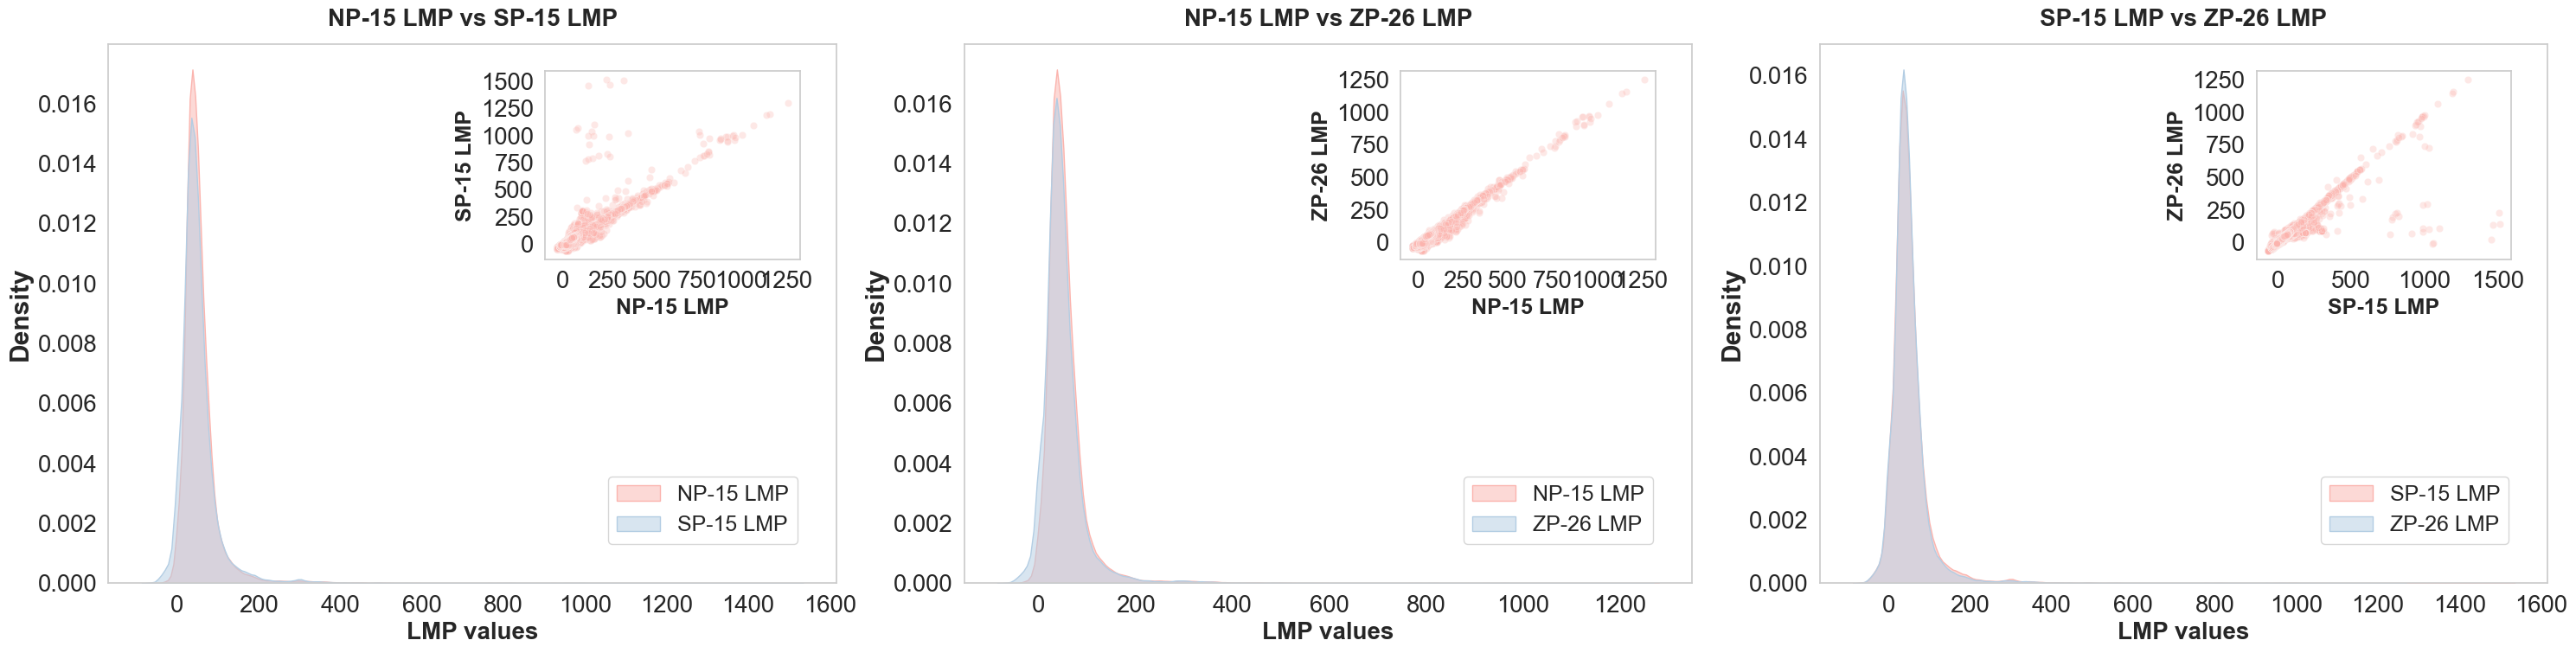

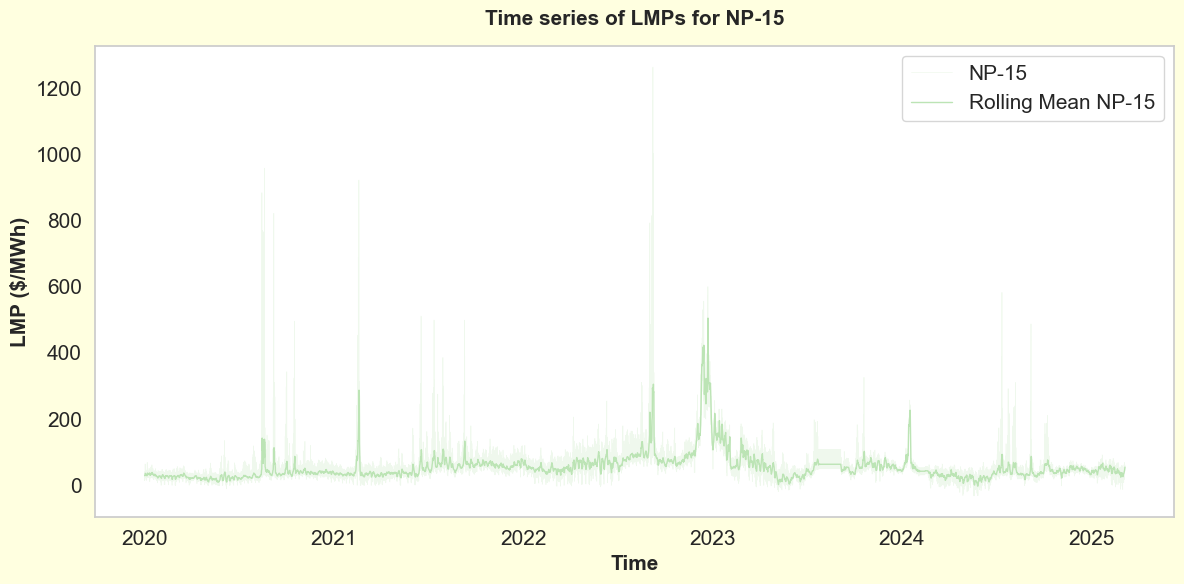

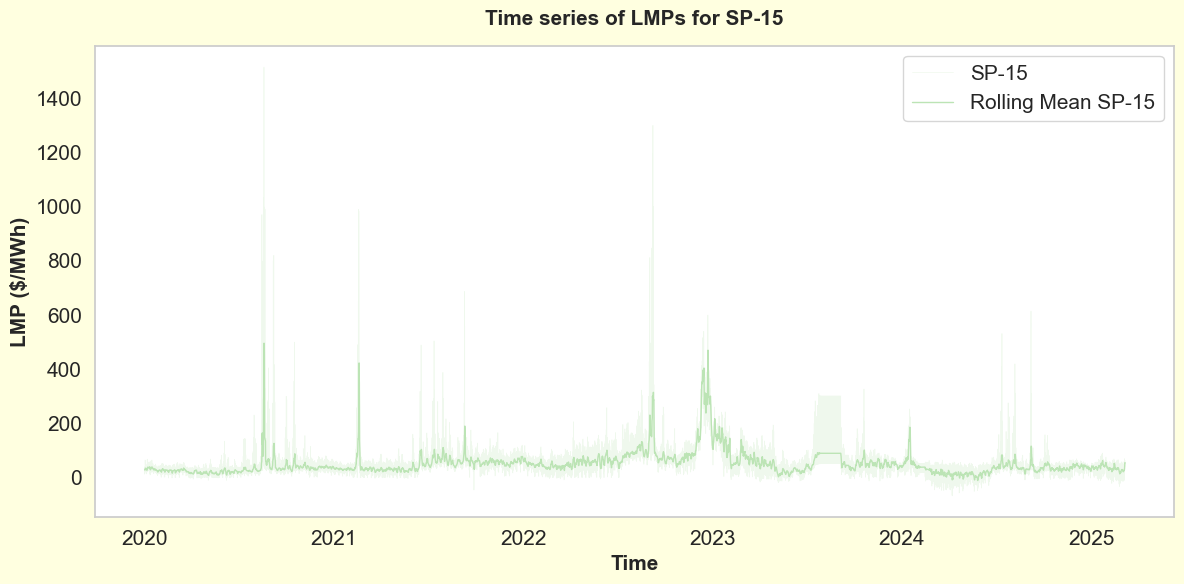

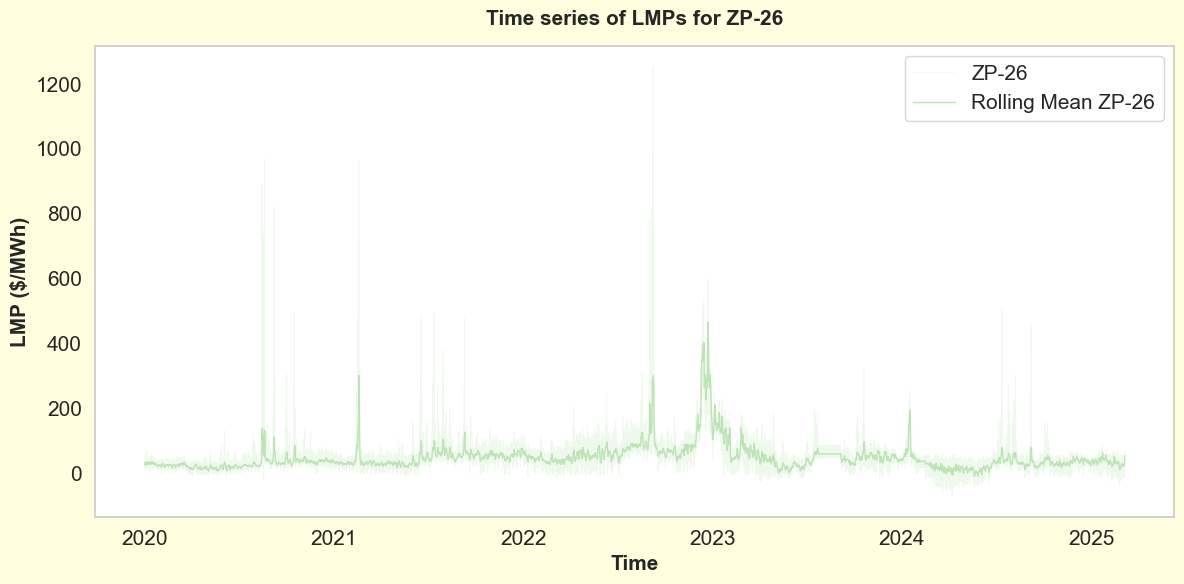

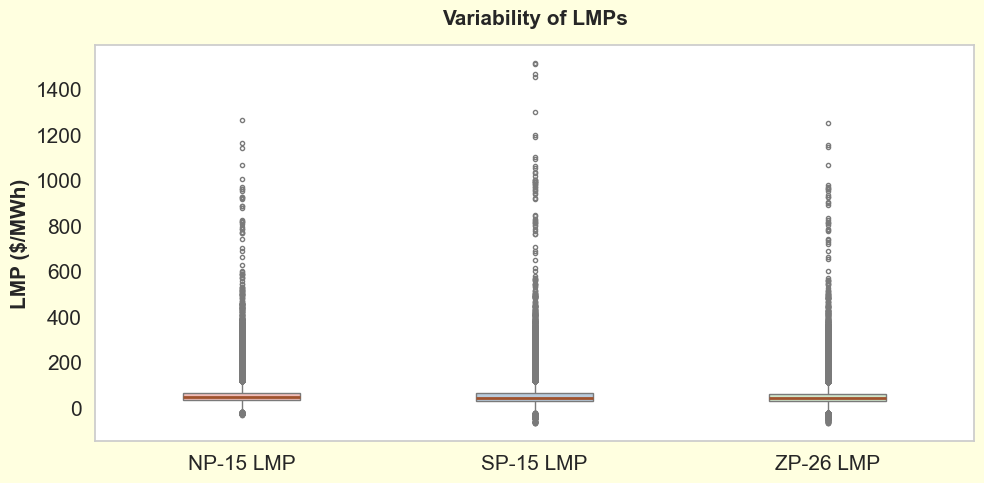

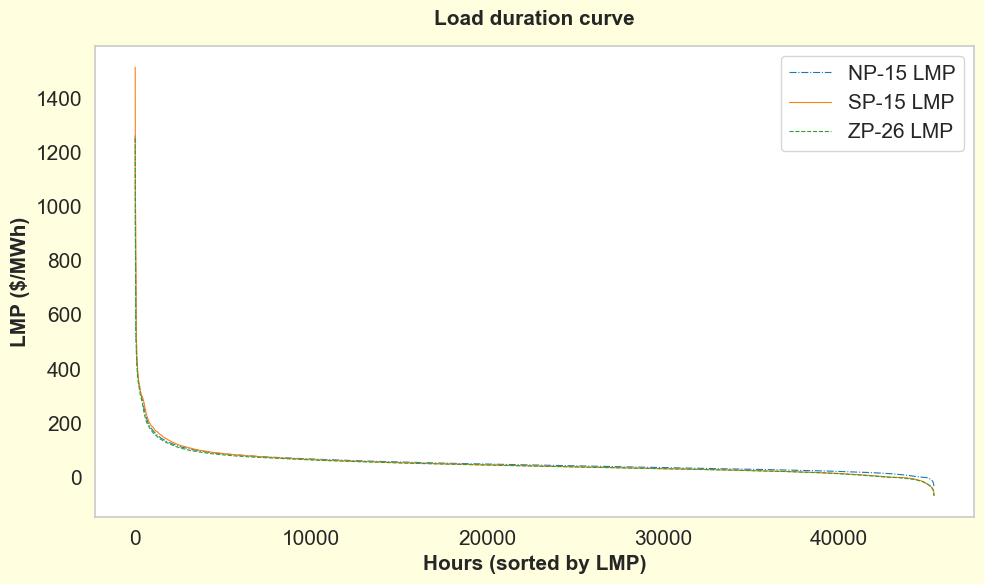

In [12]:
plot_distrib(imputed_df, area_lmp, name='Original', status='modified')
plot_ts(imputed_df, area_lmp, areas, time_col="Local_Ending", name='Original', status='modified')

plot_boxplots(imputed_df, area_lmp, name='Original', status='modified')
plot_load_durations(imputed_df, area_lmp, name='Original', status='modified')

local_df = set_index(imputed_df, "Local_Ending")
print("\n Local Time-based data preview:")
print(local_df.head())

statistics = compute_statistics(local_df, area_lmp)

NP-15 LMP 31.1327025 64.4825475 33.349844999999995 -18.892064999999995 114.50731499999999
SP-15 LMP 26.68394875 62.4082275 35.72427875 -26.90246937500001 115.994645625
ZP-26 LMP 26.616045 60.82069 34.204645 -24.6909225 112.1276575

 Local Time-based data preview:
                           NP-15 LMP  SP-15 LMP  ZP-26 LMP
Local_Ending                                              
2020-01-01 01:00:00-08:00   32.76137   32.43968   32.43298
2020-01-01 02:00:00-08:00   30.90384   30.15999   30.22250
2020-01-01 03:00:00-08:00   32.15974   31.27101   31.38129
2020-01-01 04:00:00-08:00   31.24182   30.27013   30.38648
2020-01-01 05:00:00-08:00   30.98365   29.71527   29.91375

Basic statistics:
             count       mean        std        min        25%        50%  \
NP-15 LMP  45384.0  50.073646  27.386304 -18.892065  31.132703  45.468095   
SP-15 LMP  45384.0  46.497729  30.742929 -26.902469  26.683949  42.360765   
ZP-26 LMP  45384.0  45.080423  29.409715 -24.690922  26.616045  41.746270

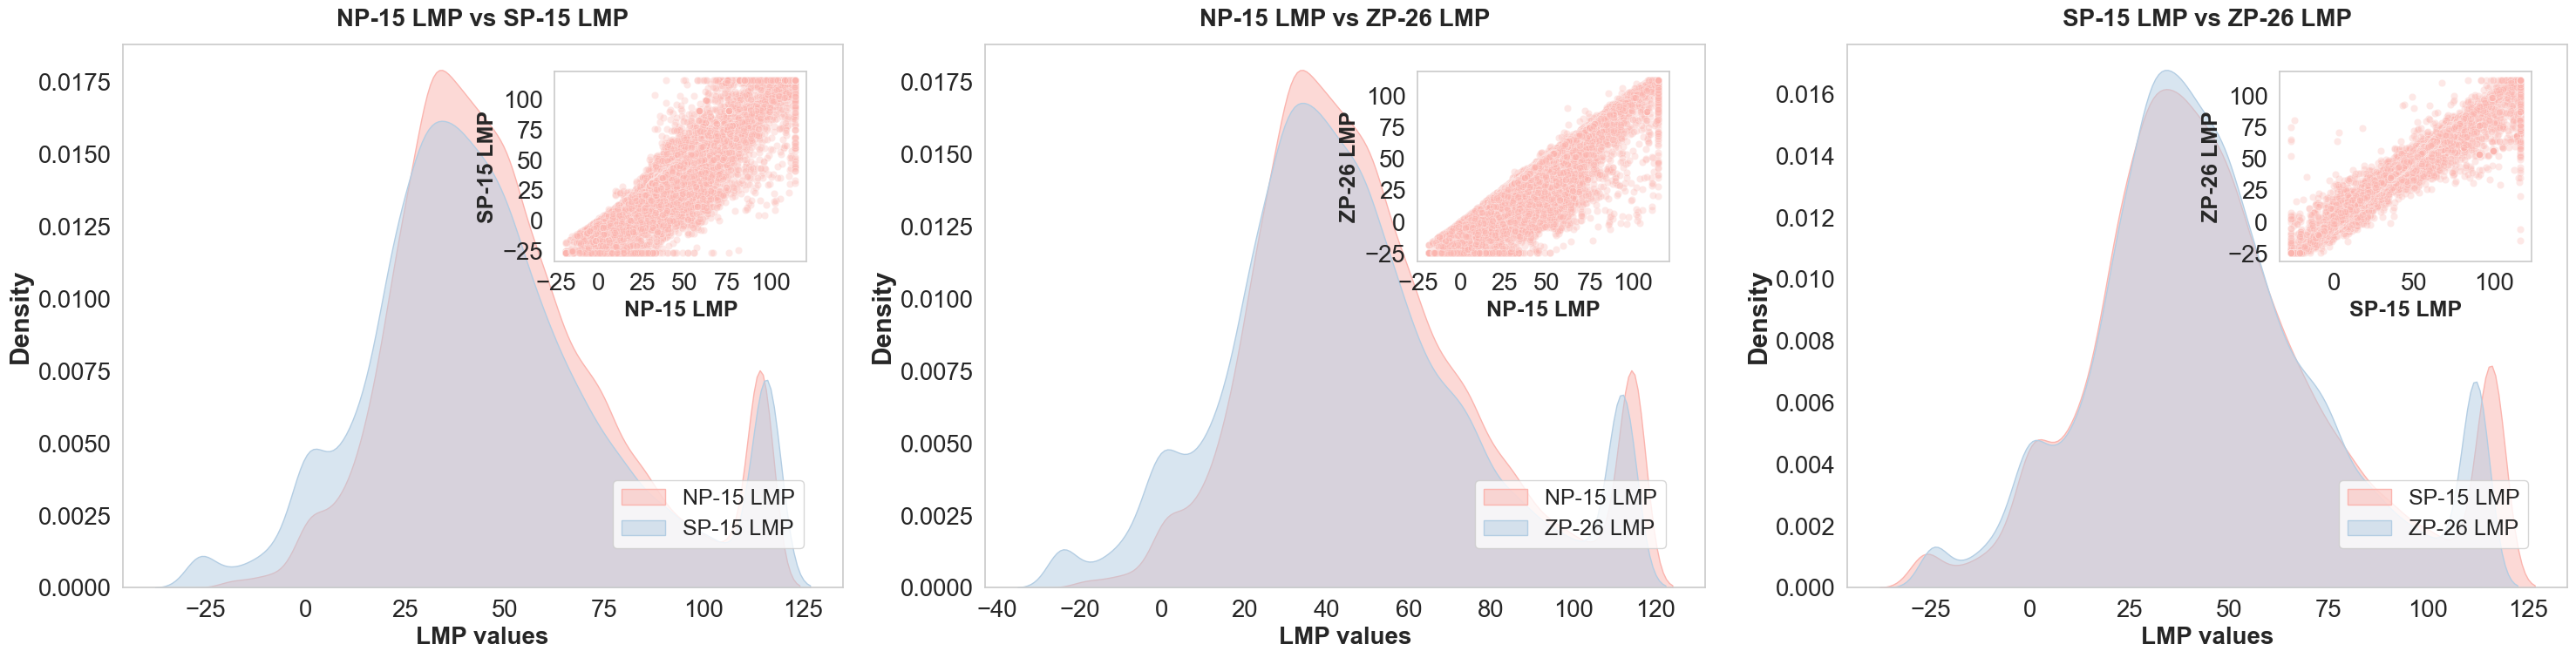

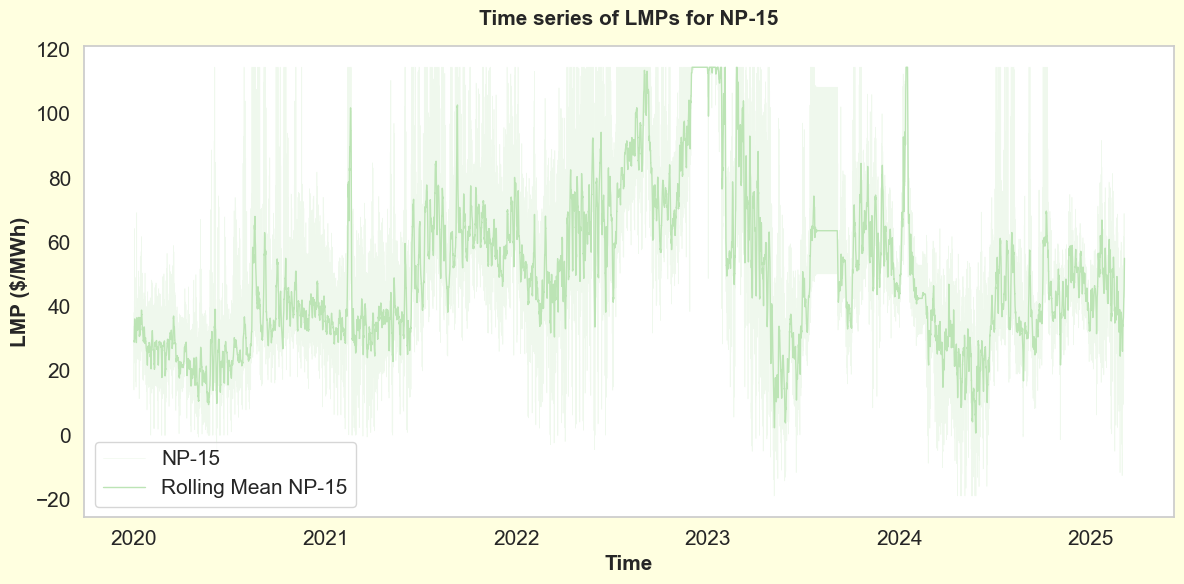

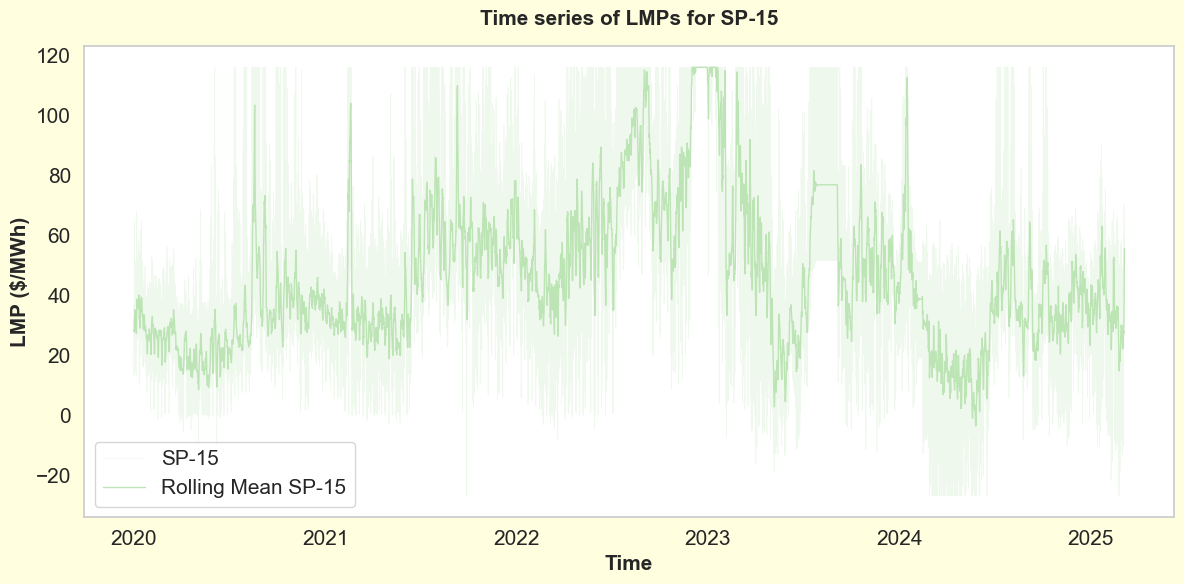

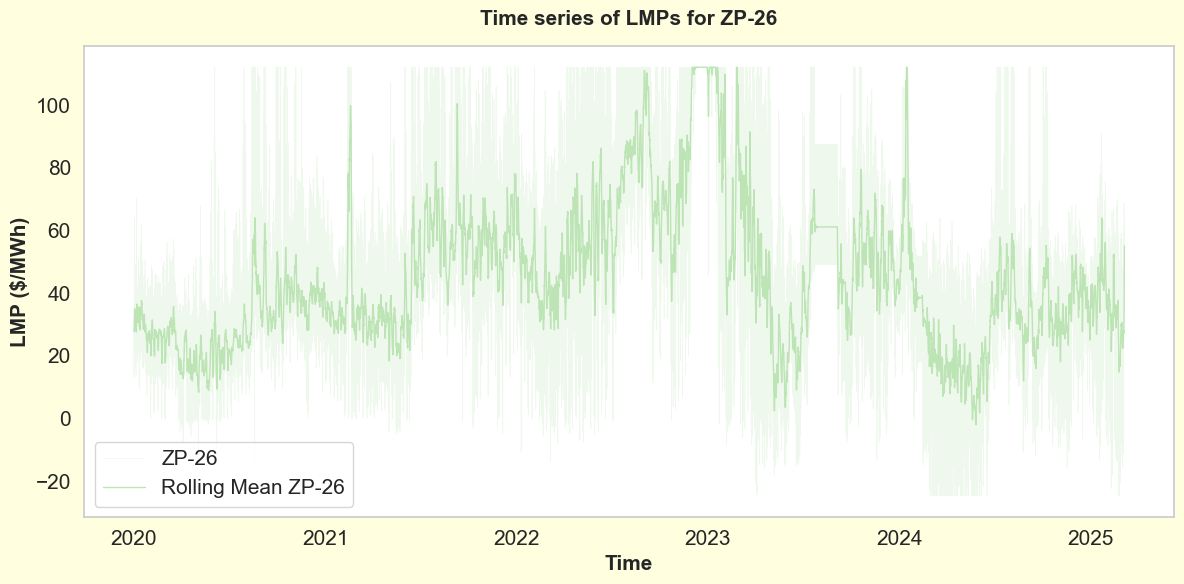

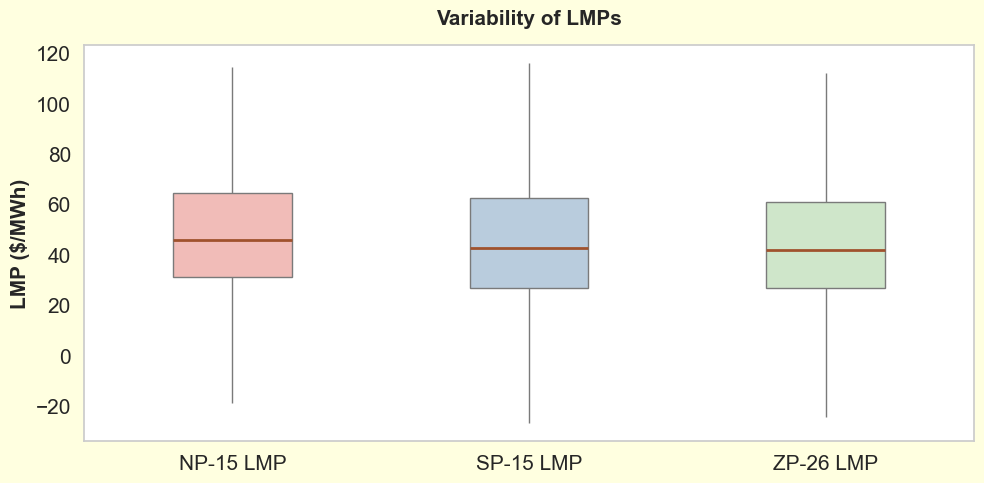

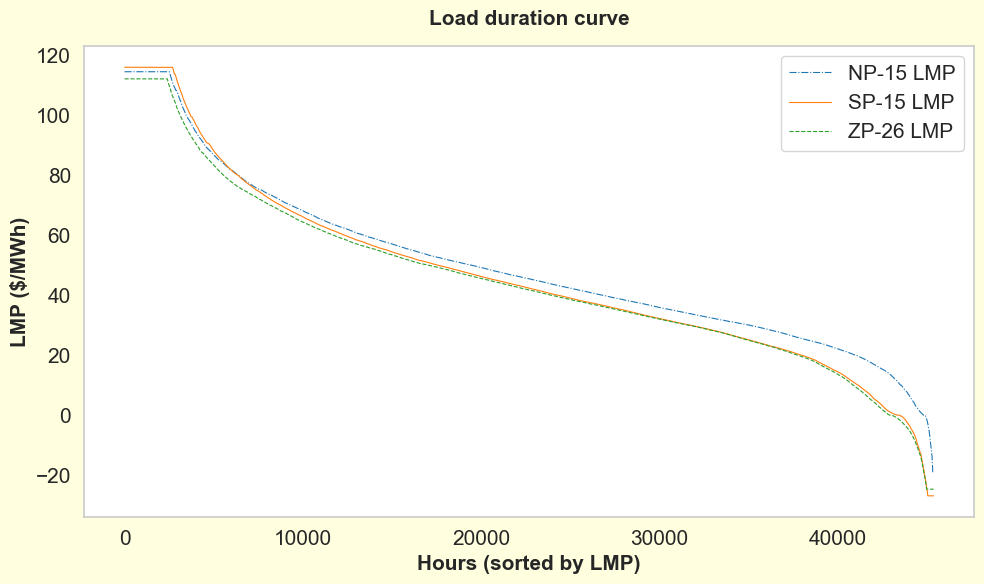

In [13]:
# outlier removal through IQR

df_tmp = imputed_df.copy()
df_tmp = remove_outliers_iqr(df_tmp, area_lmp)

plot_distrib(df_tmp, area_lmp, name='IQR', status='modified')
plot_ts(df_tmp, area_lmp, areas, time_col="Local_Ending", name='IQR', status='modified')

plot_boxplots(df_tmp, area_lmp, name='IQR', status='modified')
plot_load_durations(df_tmp, area_lmp, name='IQR', status='modified')

local_df = set_index(df_tmp, "Local_Ending")
print("\n Local Time-based data preview:")
print(local_df.head())

statistics = compute_statistics(local_df, area_lmp)

Check the data after outlier adjustment through Winsorization


 Local Time-based data preview:
                           NP-15 LMP  SP-15 LMP  ZP-26 LMP
Local_Ending                                              
2020-01-01 01:00:00-08:00   32.76137   32.43968   32.43298
2020-01-01 02:00:00-08:00   30.90384   30.15999   30.22250
2020-01-01 03:00:00-08:00   32.15974   31.27101   31.38129
2020-01-01 04:00:00-08:00   31.24182   30.27013   30.38648
2020-01-01 05:00:00-08:00   30.98365   29.71527   29.91375

Basic statistics:
             count       mean        std       min        25%        50%  \
NP-15 LMP  45384.0  53.608027  39.490582  -0.13000  31.132703  45.468095   
SP-15 LMP  45384.0  50.565197  44.367196 -21.44707  26.683949  42.360765   
ZP-26 LMP  45384.0  48.266331  40.058650 -22.00000  26.616045  41.746270   

                 75%        max  skewness   kurtosis  
NP-15 LMP  64.482547  269.29288  2.710853  10.636341  
SP-15 LMP  62.408228  288.00000  2.553410   9.829377  
ZP-26 LMP  60.820690  257.12604  2.267084   8.486310  


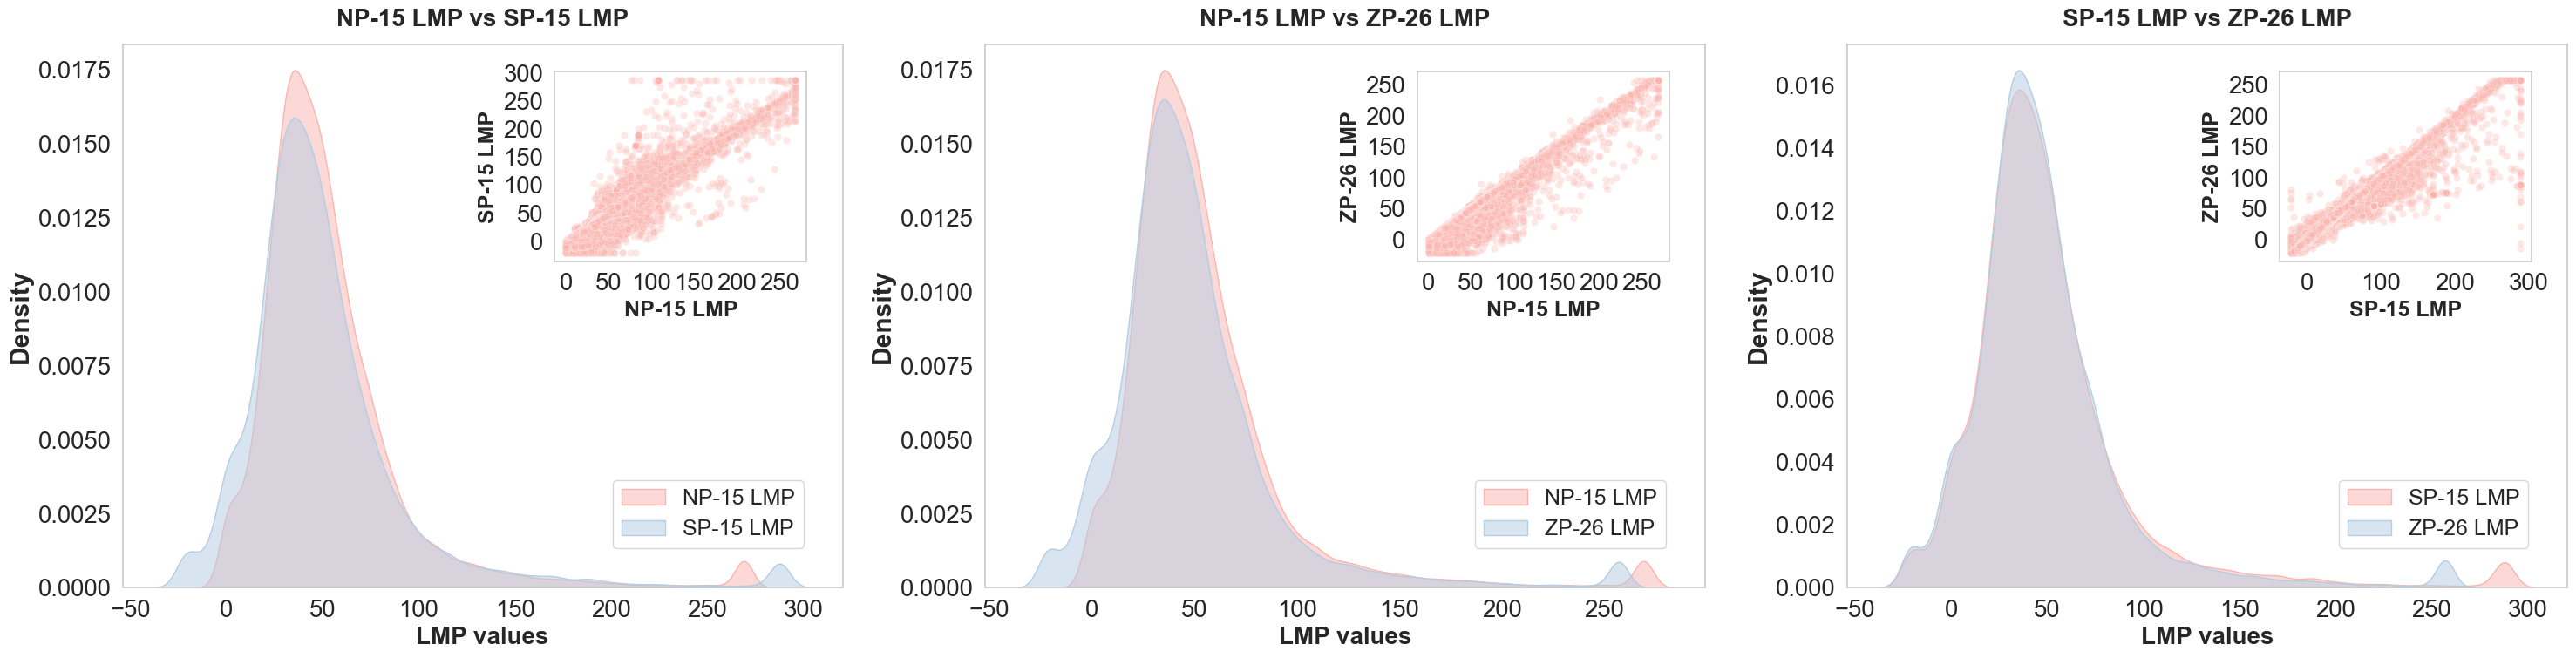

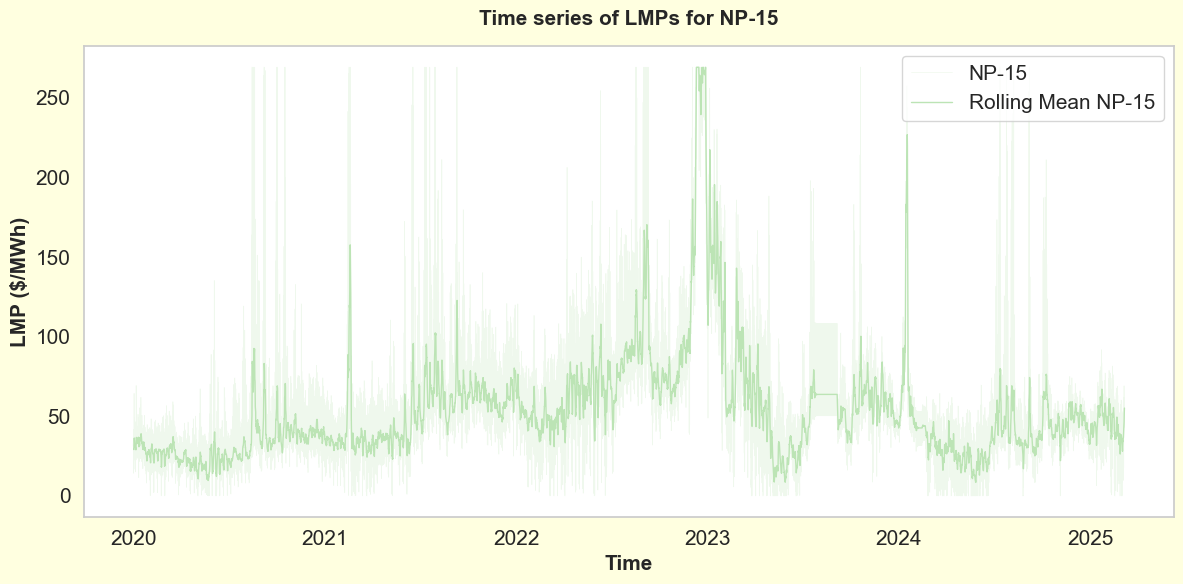

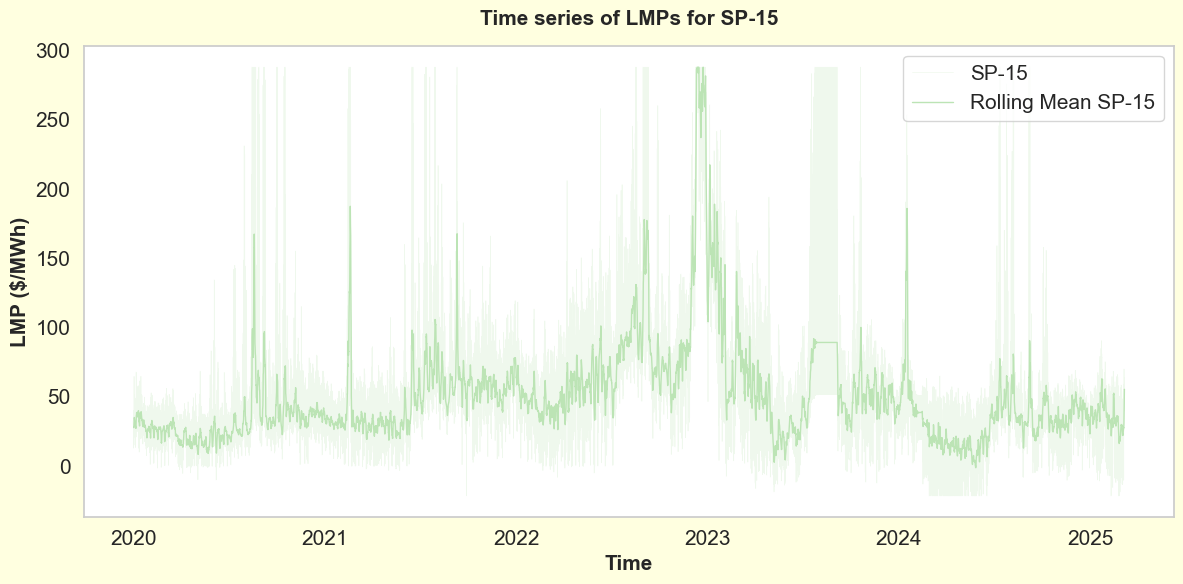

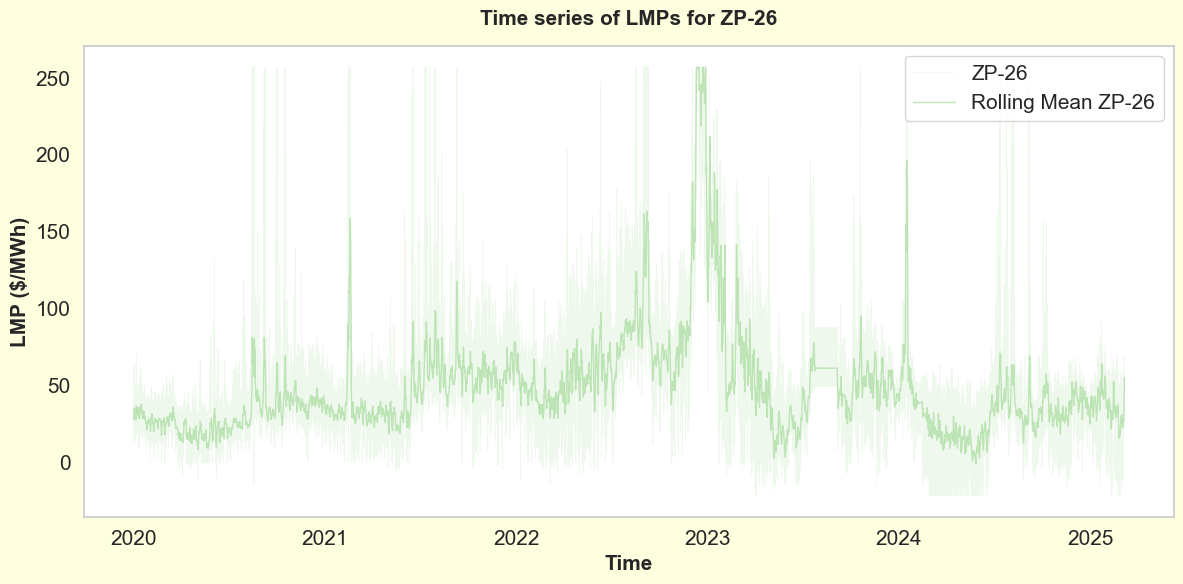

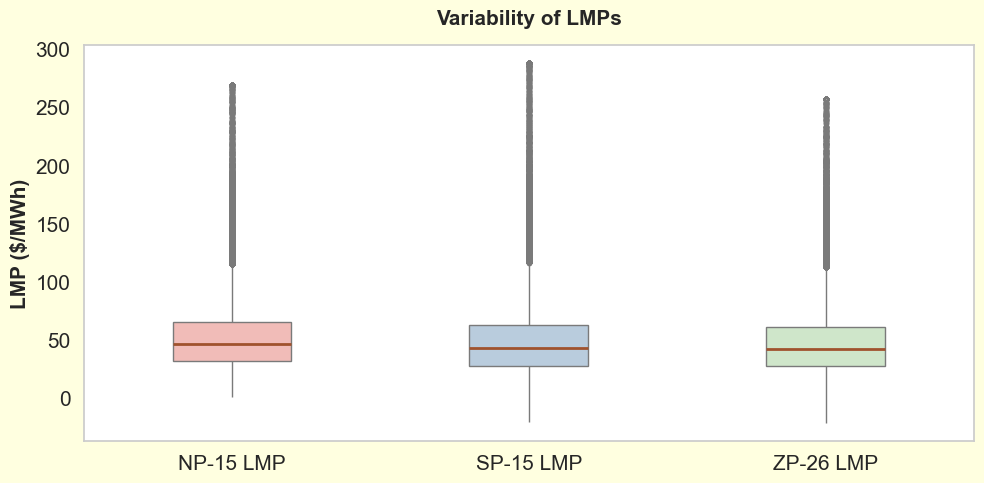

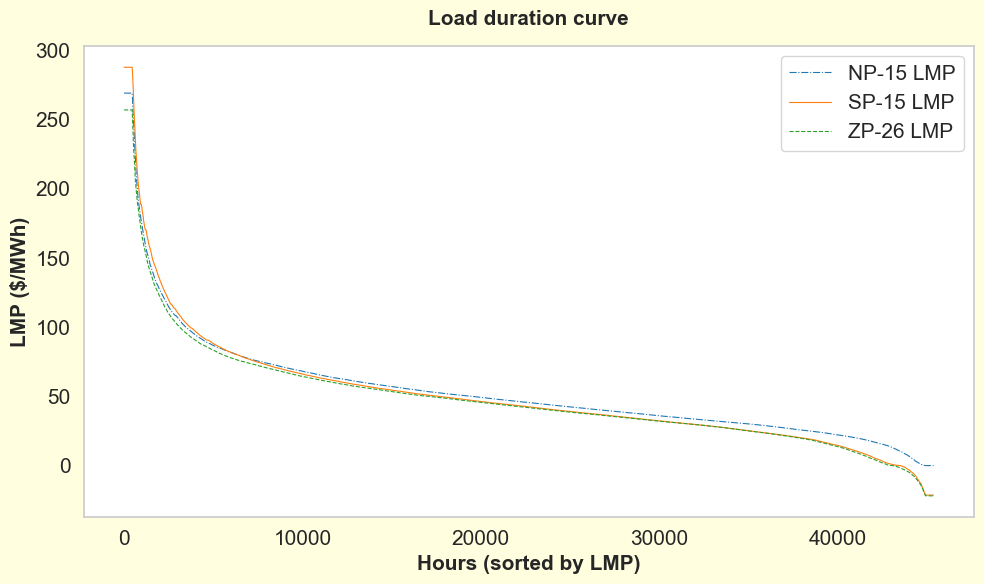

In [15]:
# outlier removal through winsorization

df_tmp = imputed_df.copy()
df_tmp = winsorize_outliers(df_tmp, area_lmp)

plot_distrib(df_tmp, area_lmp, name='Winsorization', status='modified')
plot_ts(df_tmp, area_lmp, areas, time_col="Local_Ending", name='Winsorization', status='modified')

plot_boxplots(df_tmp, area_lmp, name='Winsorization', status='modified')
plot_load_durations(df_tmp, area_lmp, name='Winsorization', status='modified')

local_df = set_index(df_tmp, "Local_Ending")
print("\n Local Time-based data preview:")
print(local_df.head())

statistics = compute_statistics(local_df, area_lmp)

### Display the returns time-series for the test part only, with different model orders.
This is strictly a sensitivity check.

ADF Statistic: -8.401795
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject the null hypothesis: Time series is stationary
ADF Statistic: -6.789729
p-value: 0.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Reject the null hypothesis: Time series is stationary
ADF Statistic: -6.465562
p-value: 0.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Reject the null hypothesis: Time series is stationary


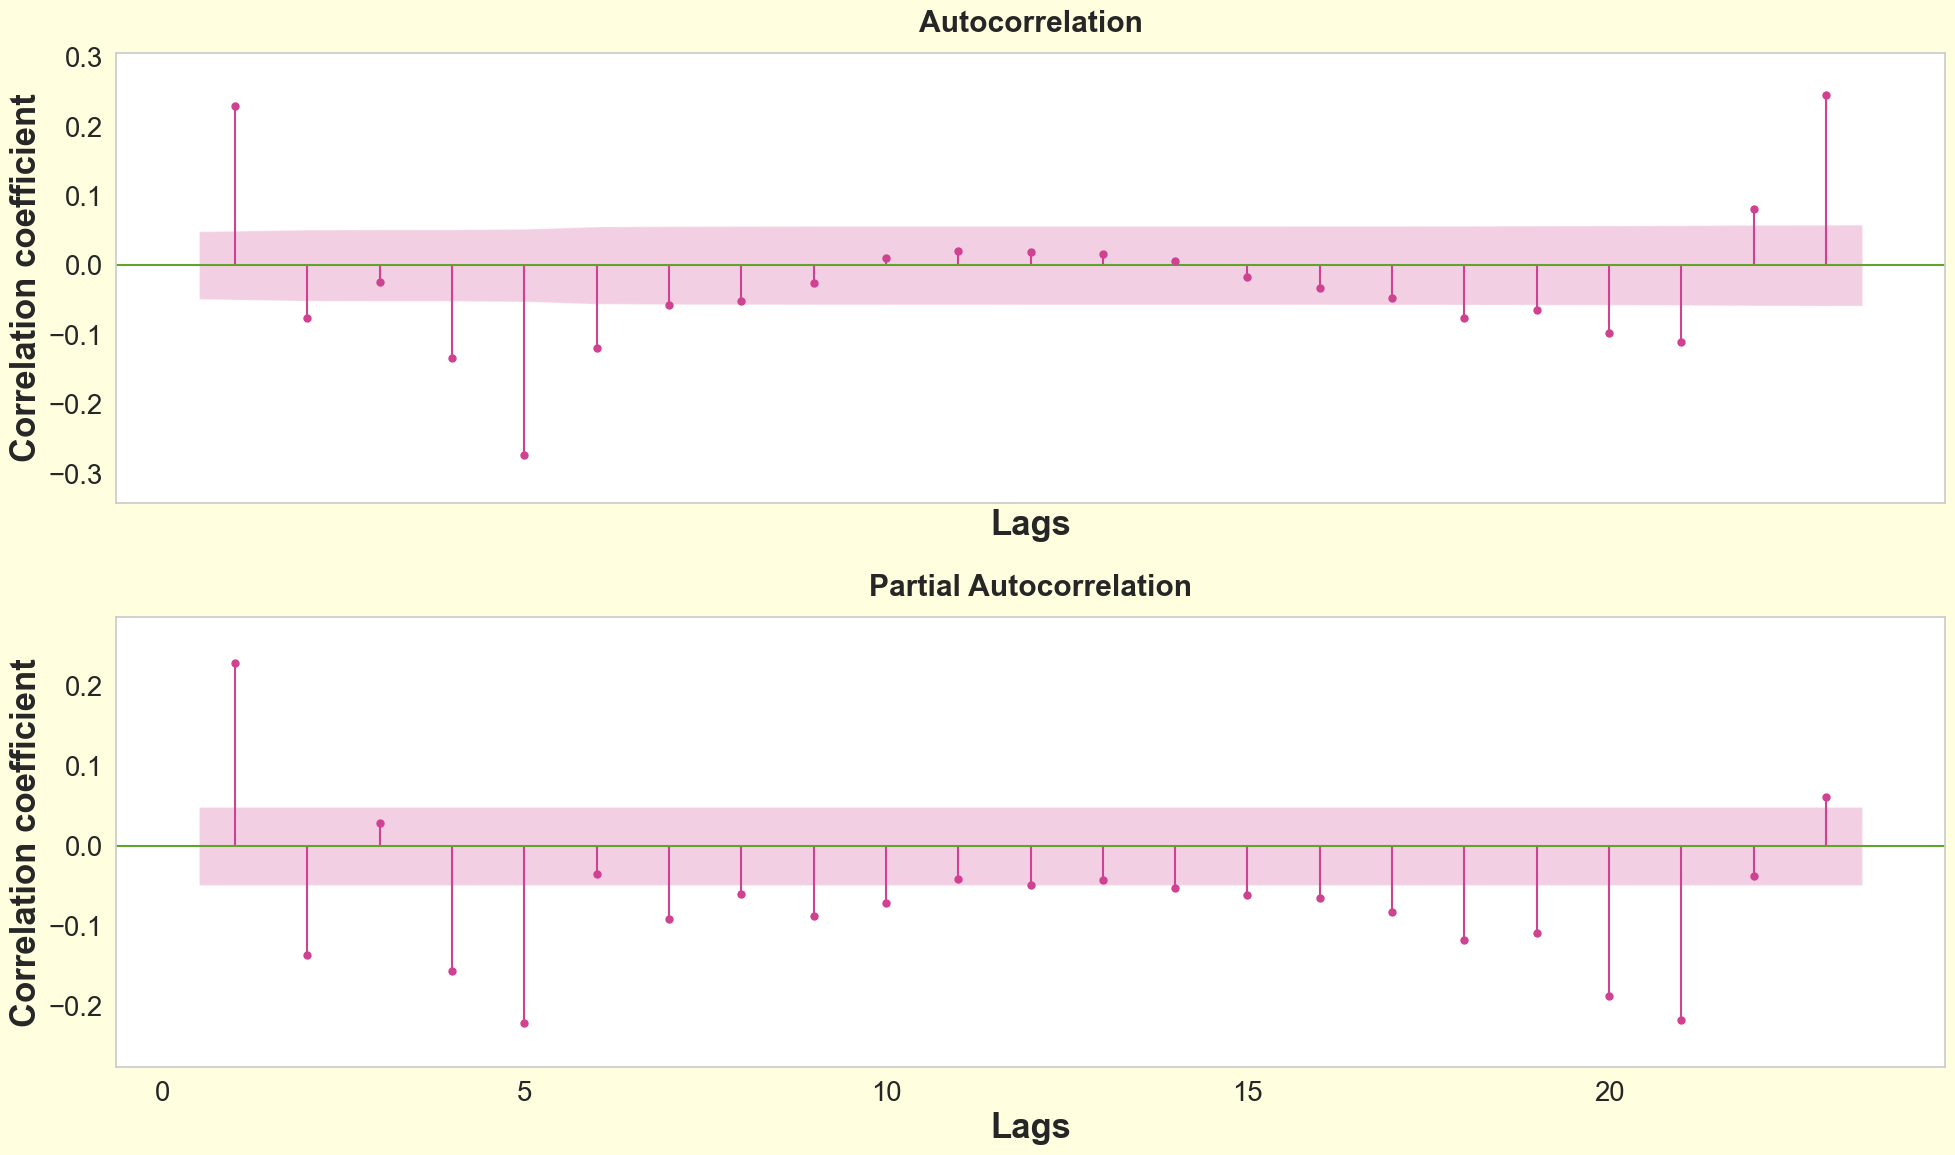

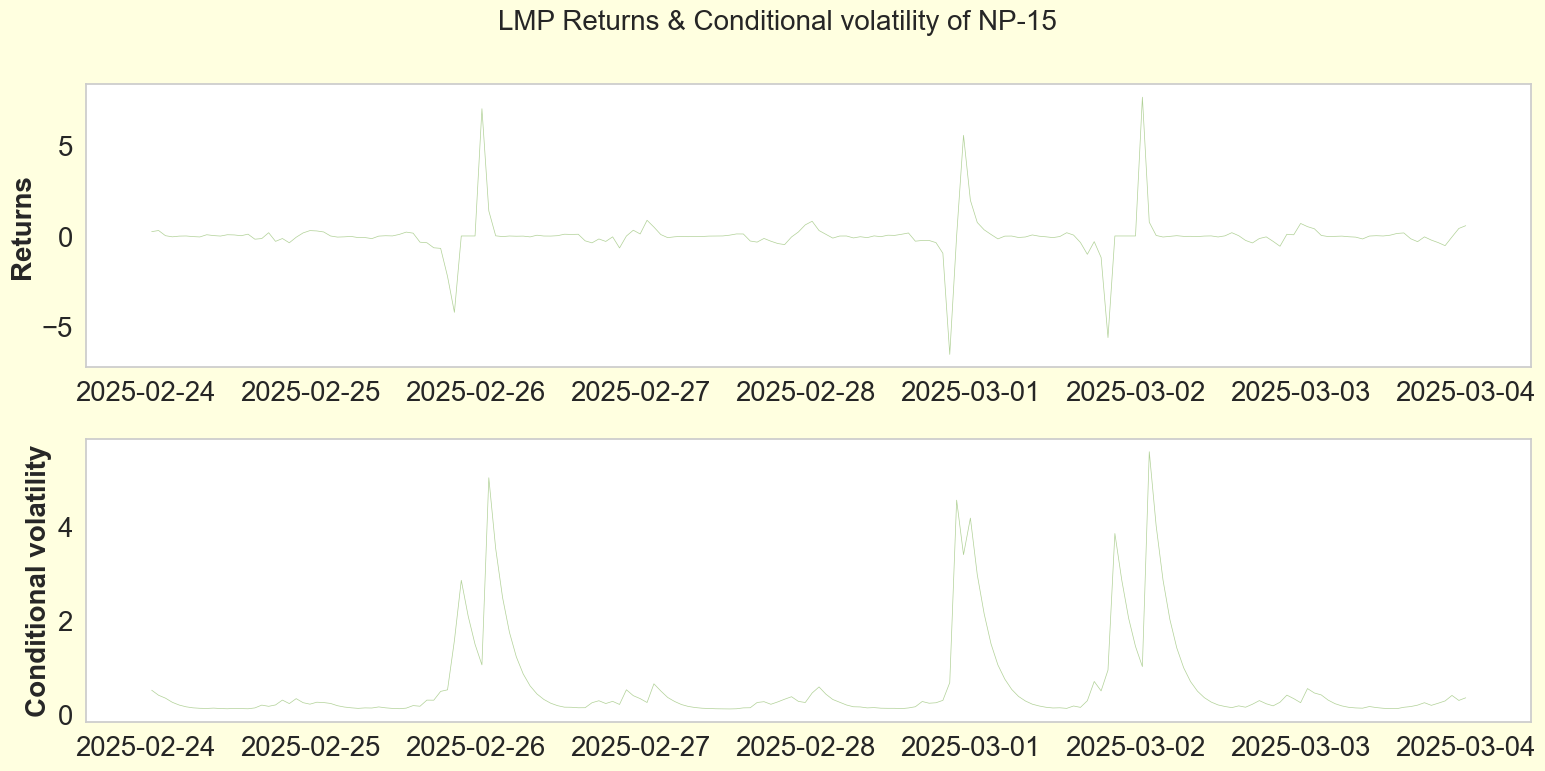

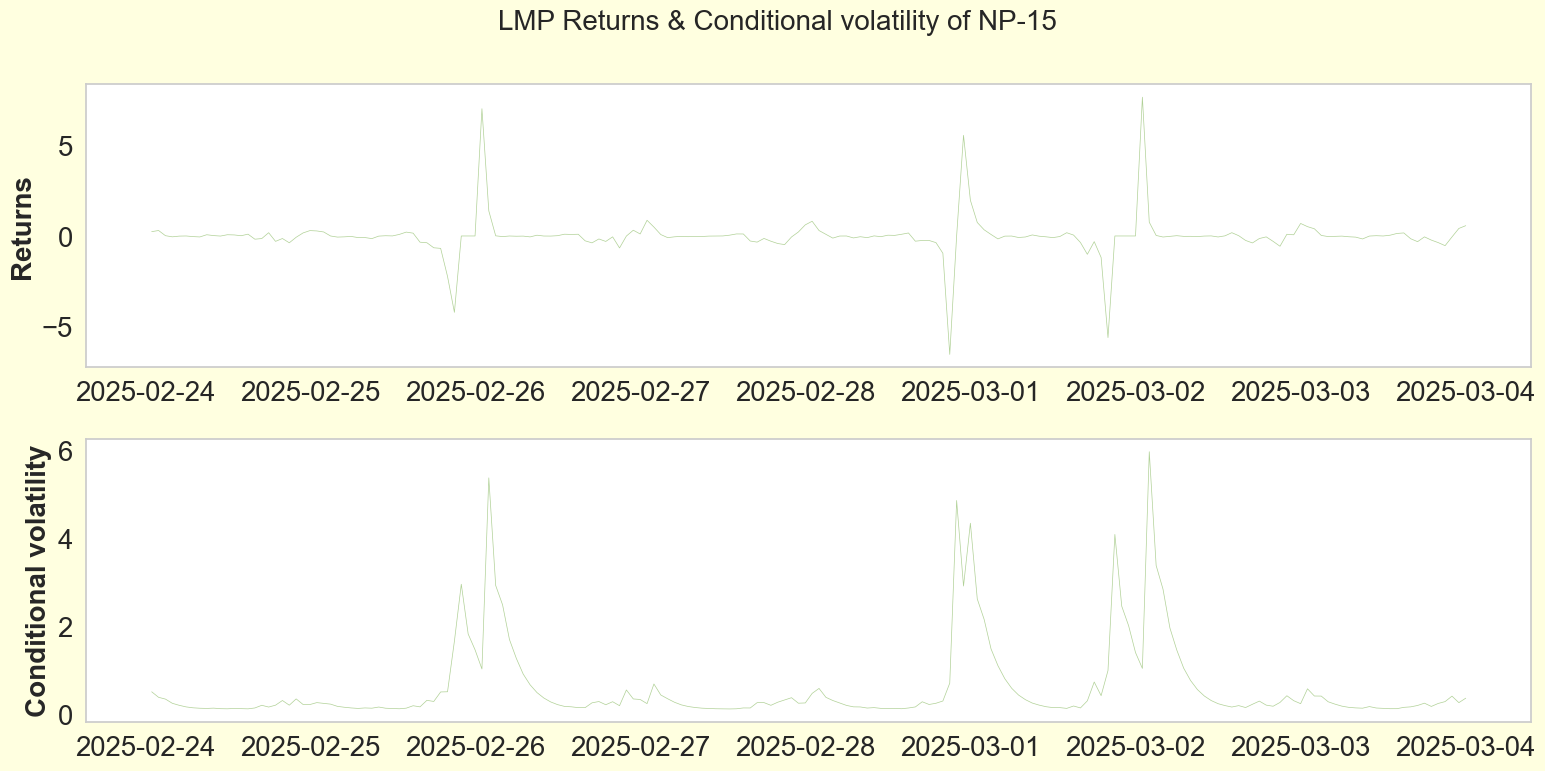

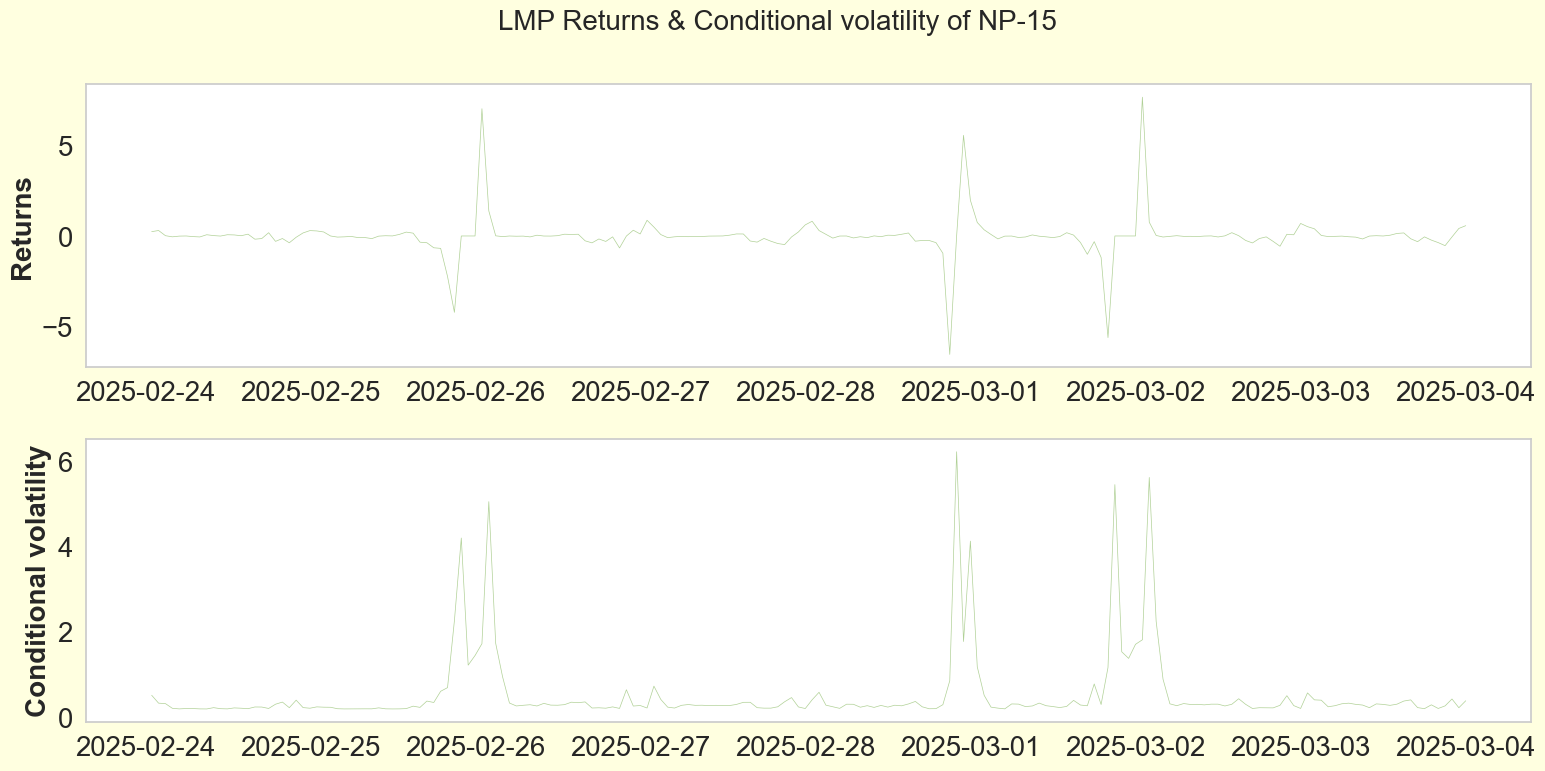

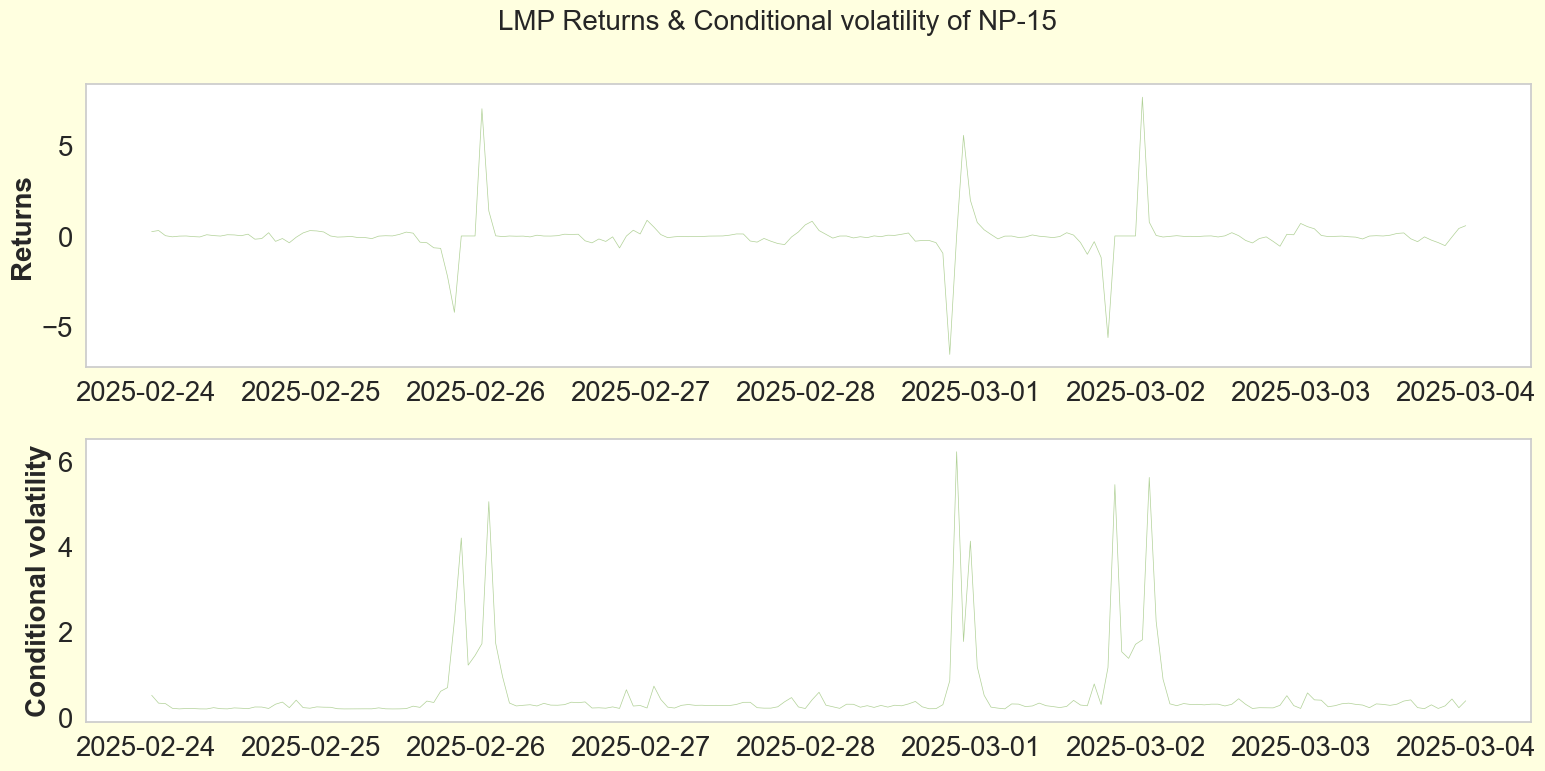

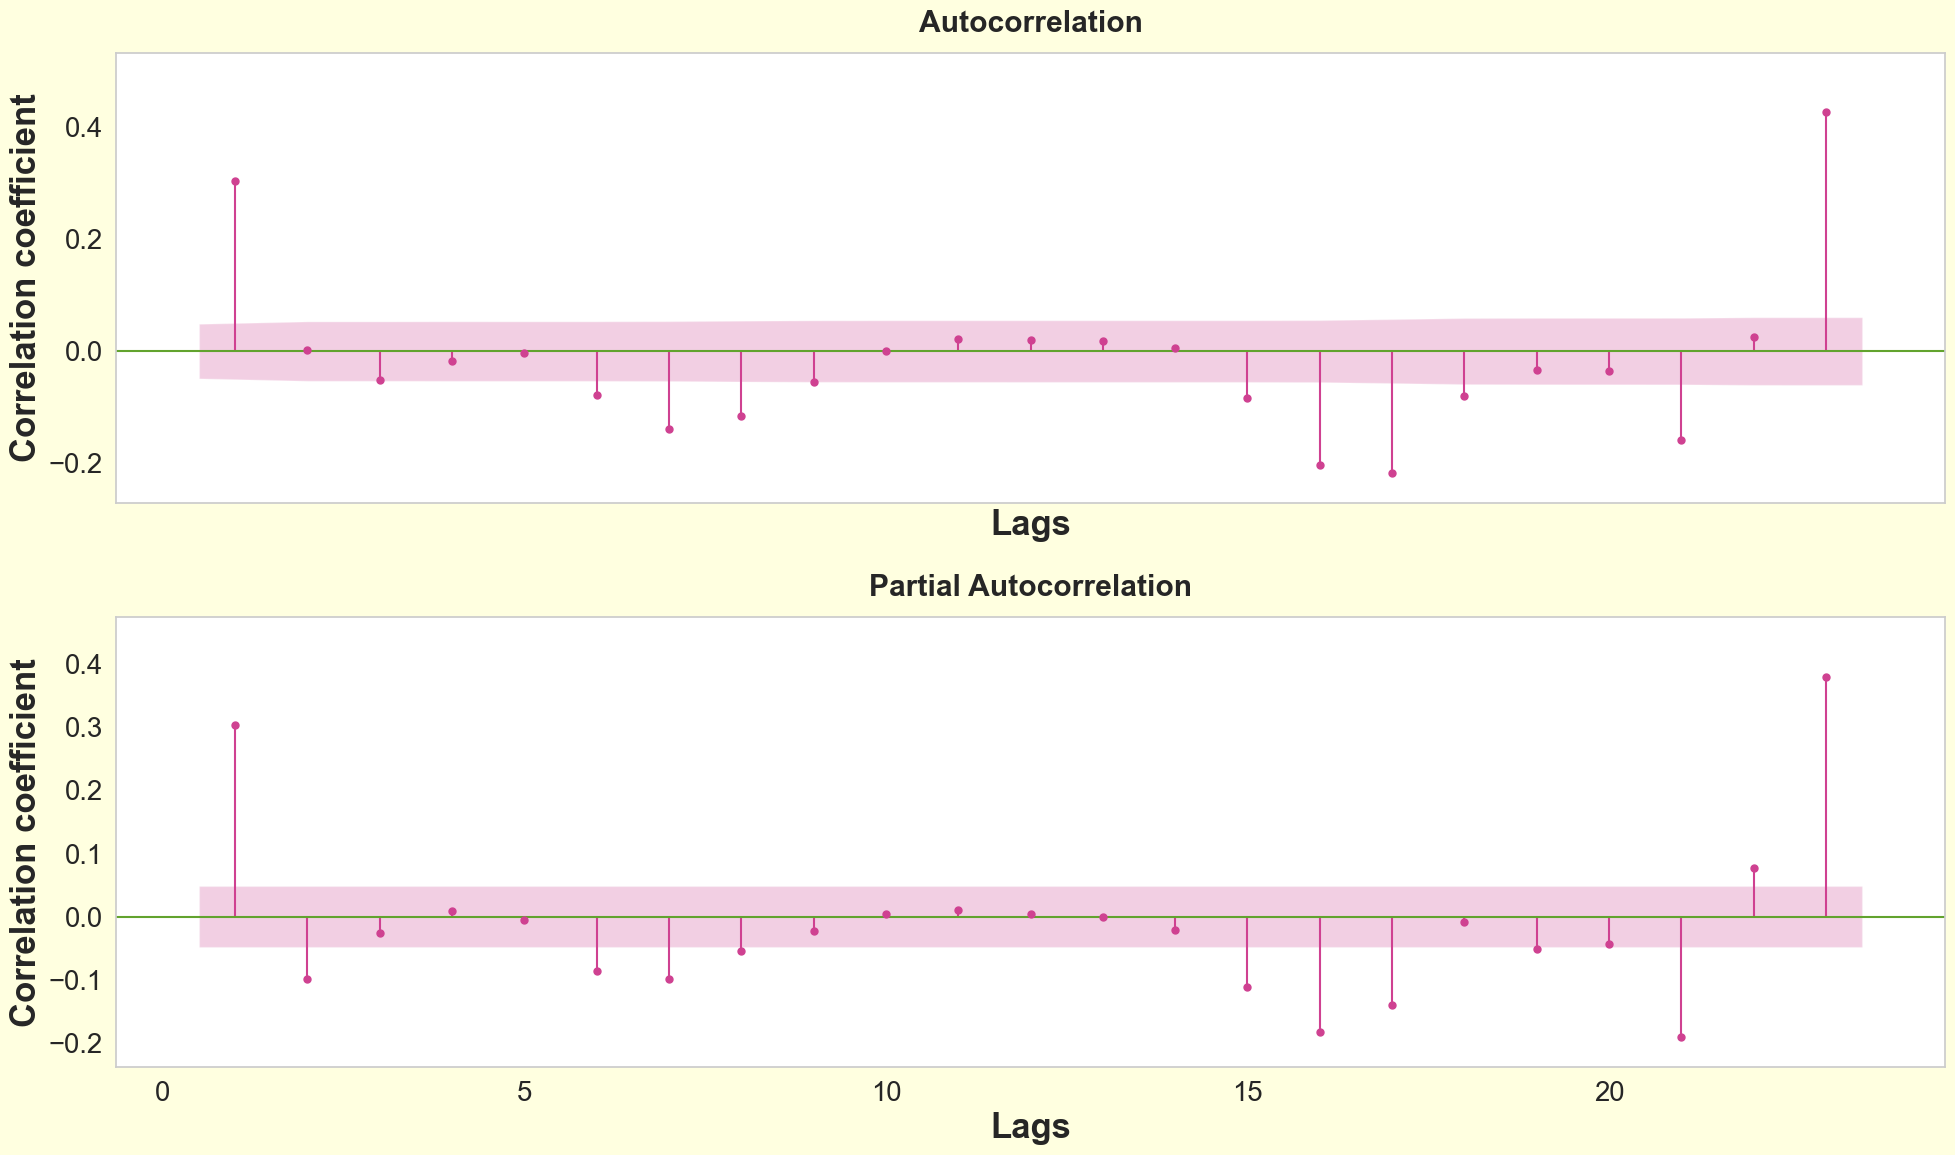

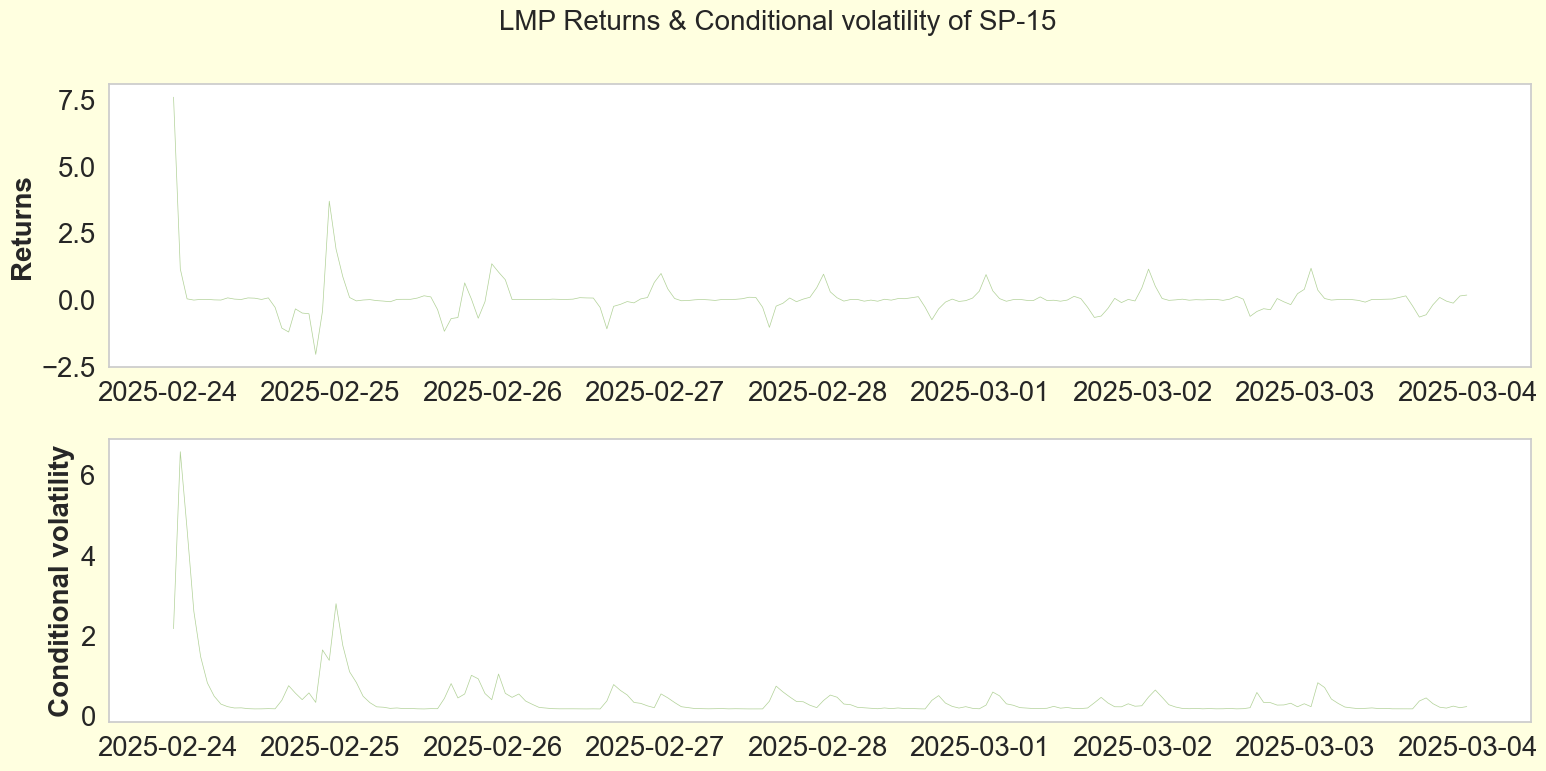

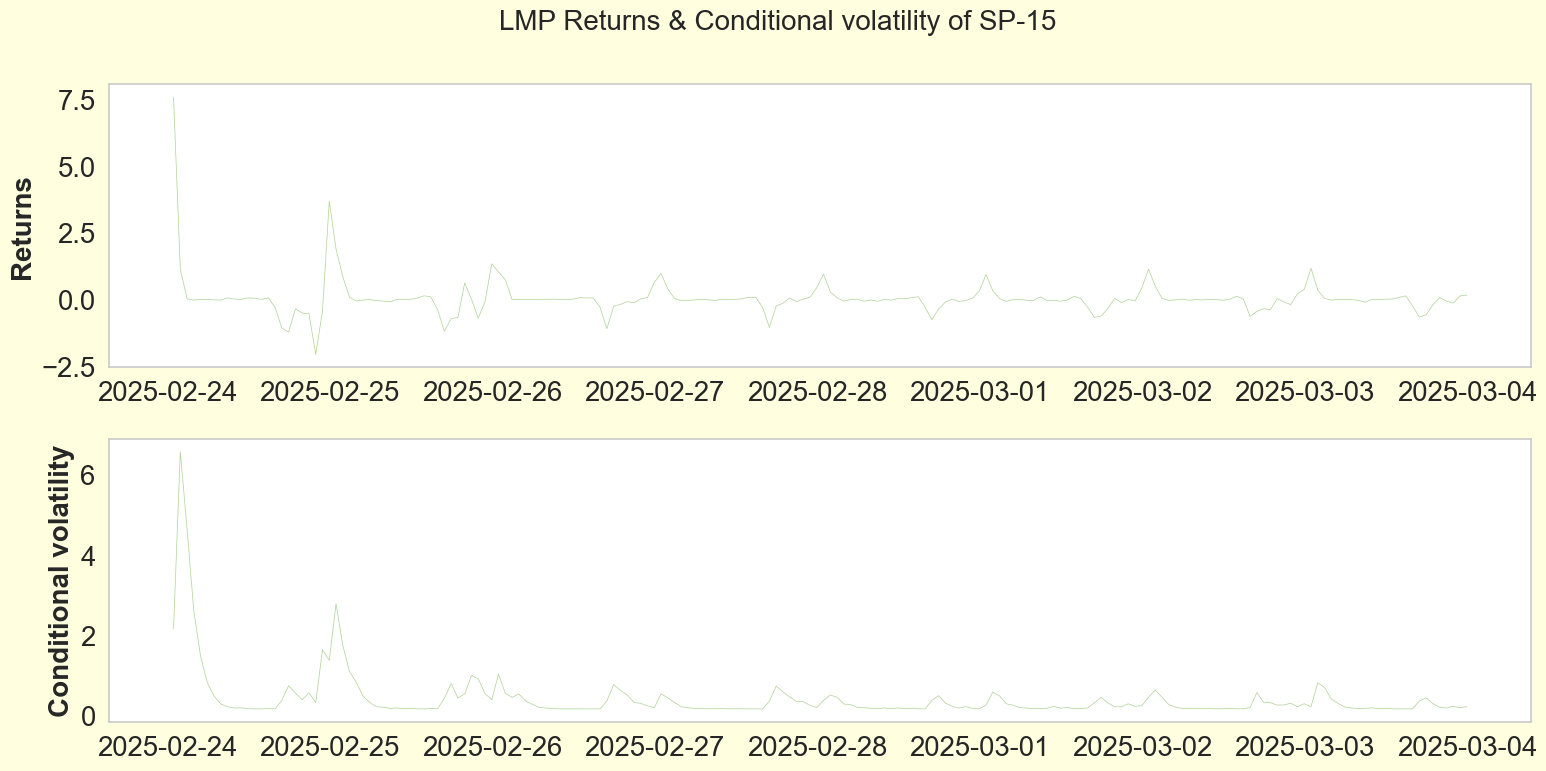

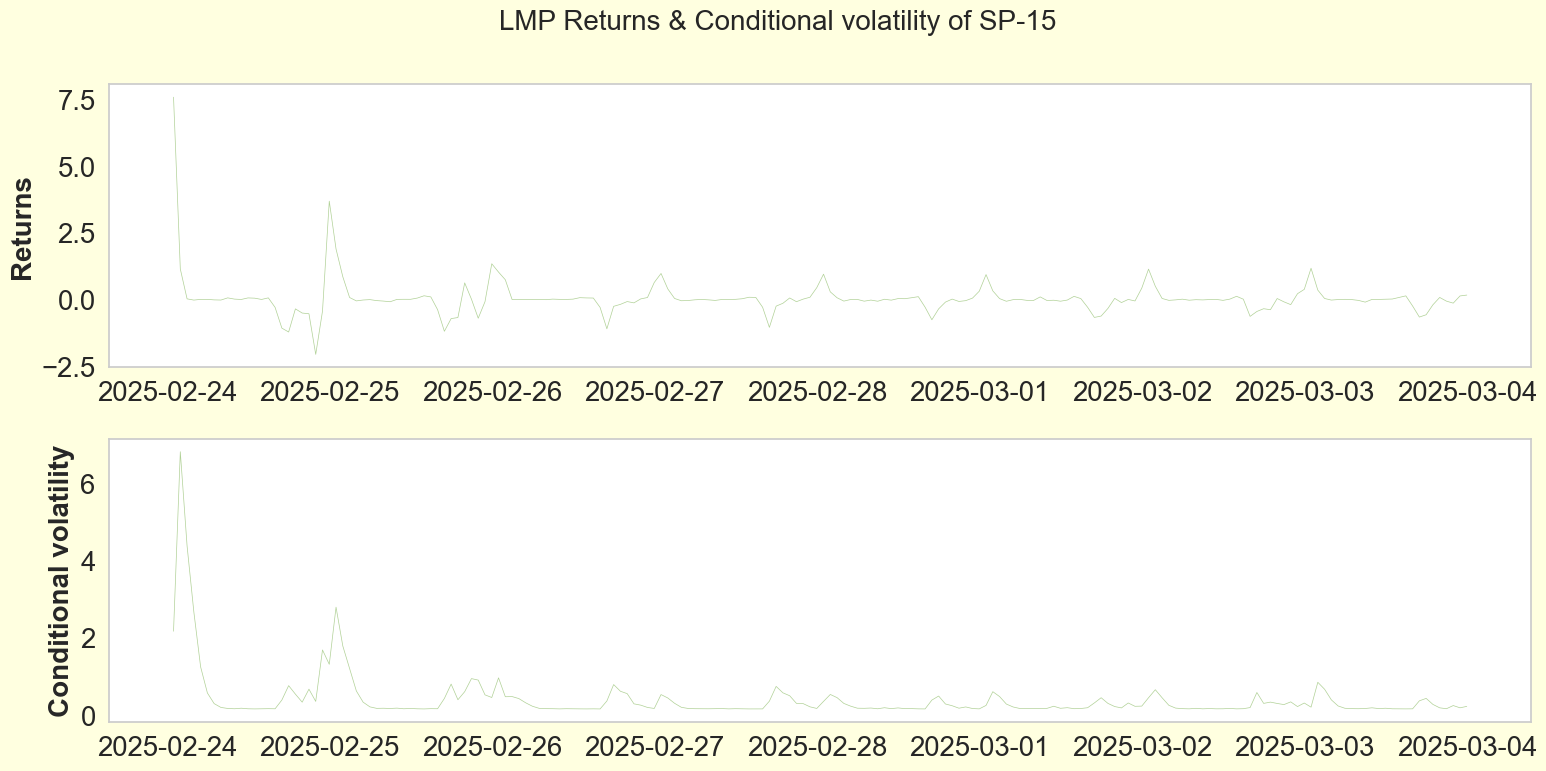

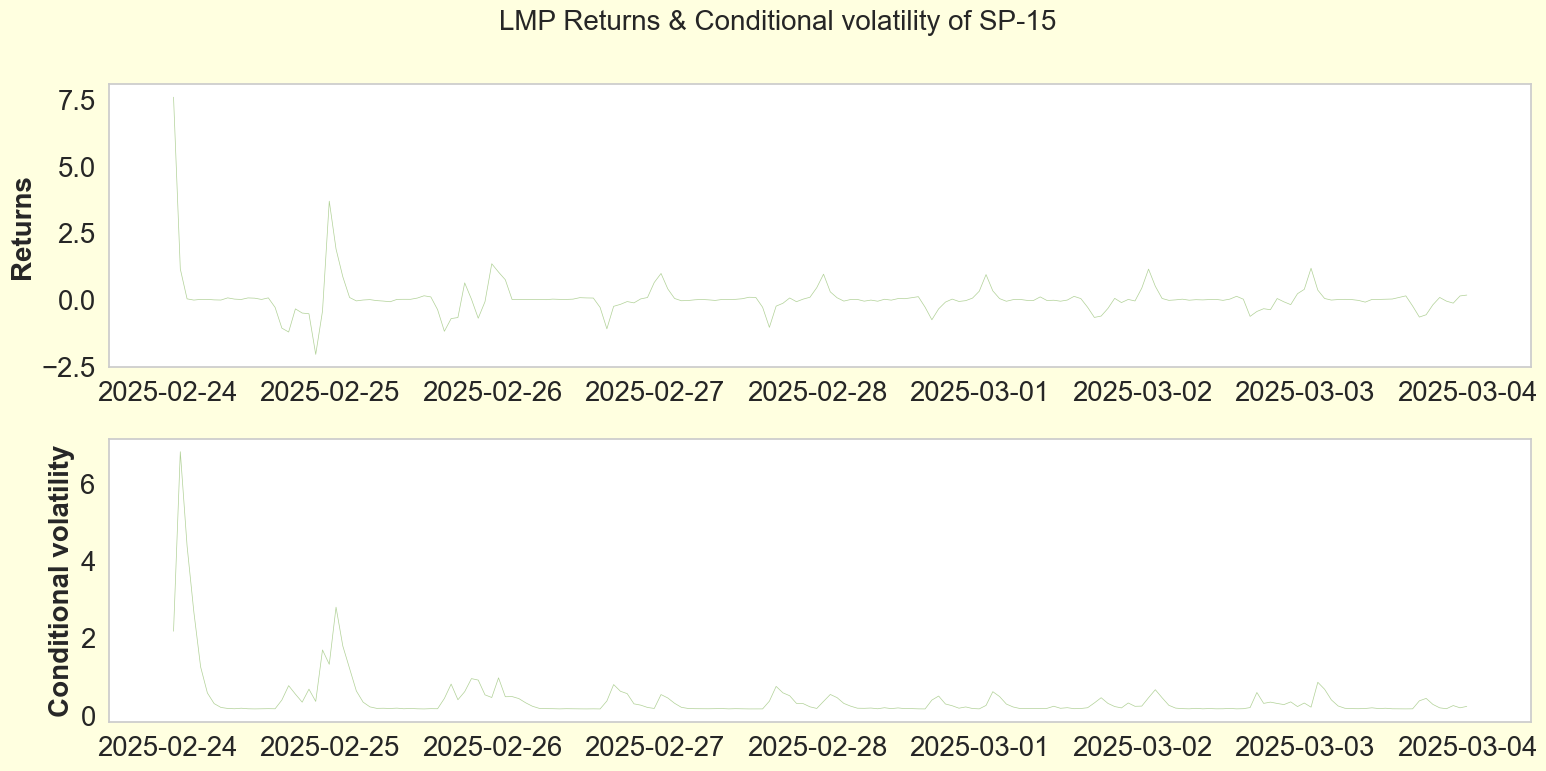

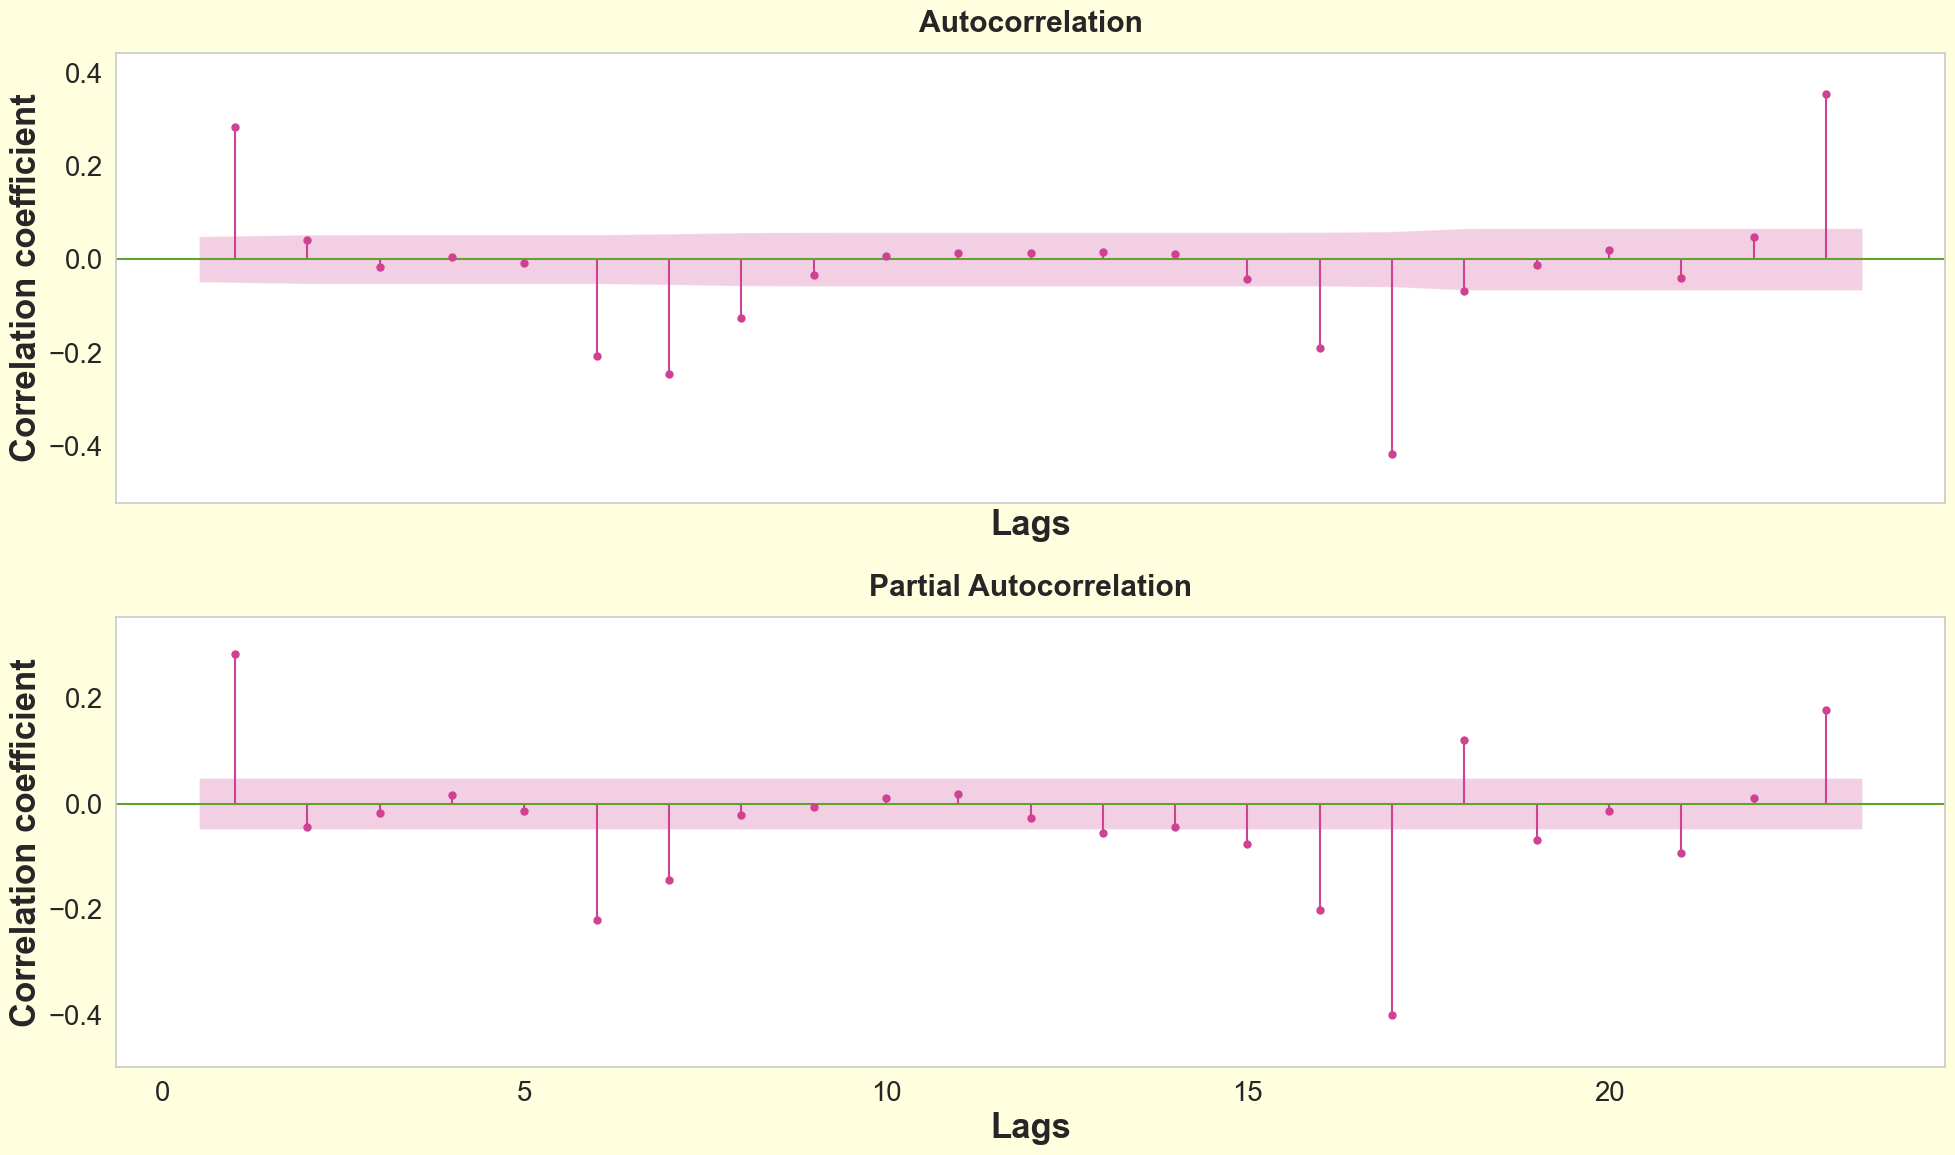

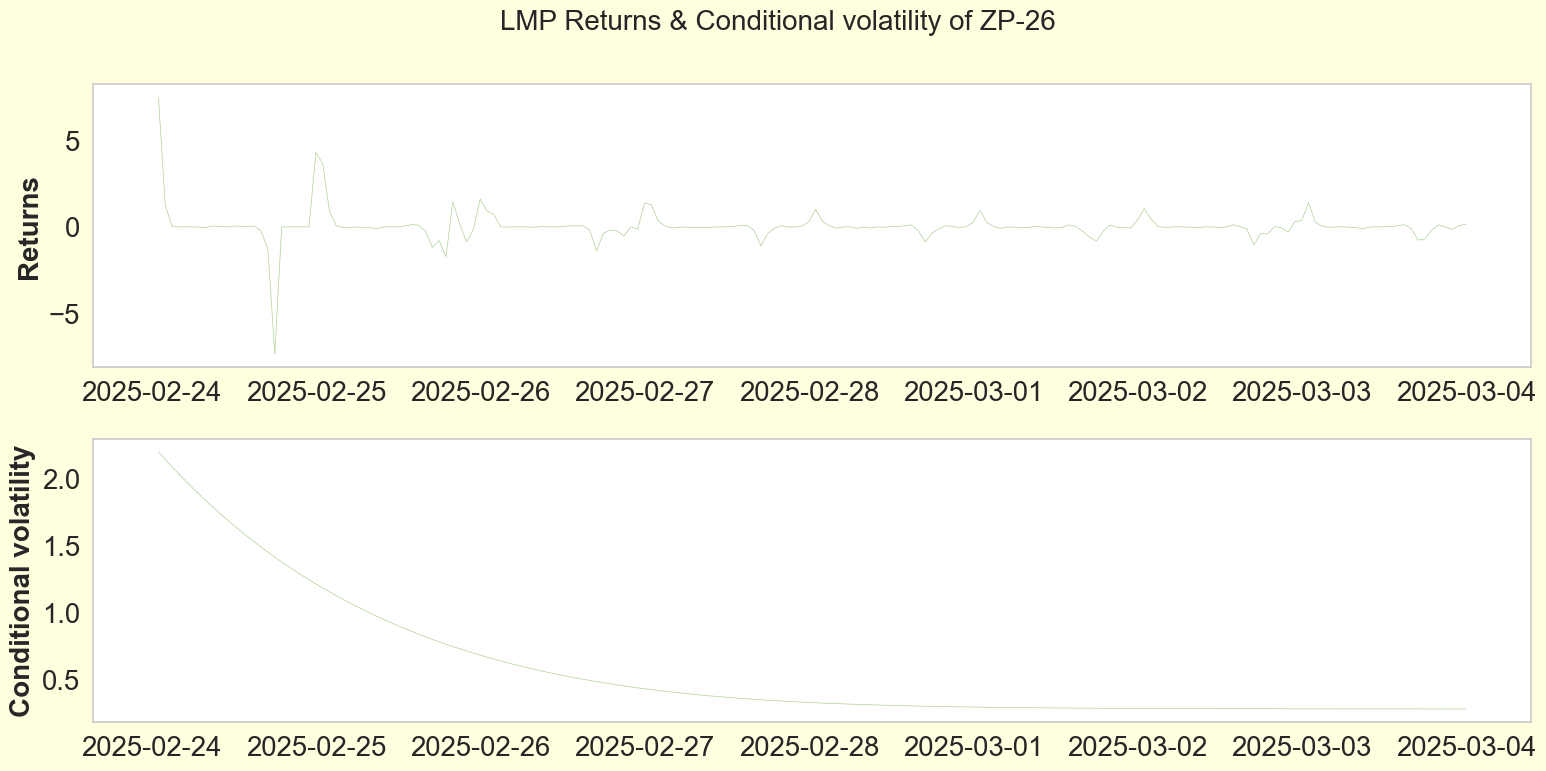

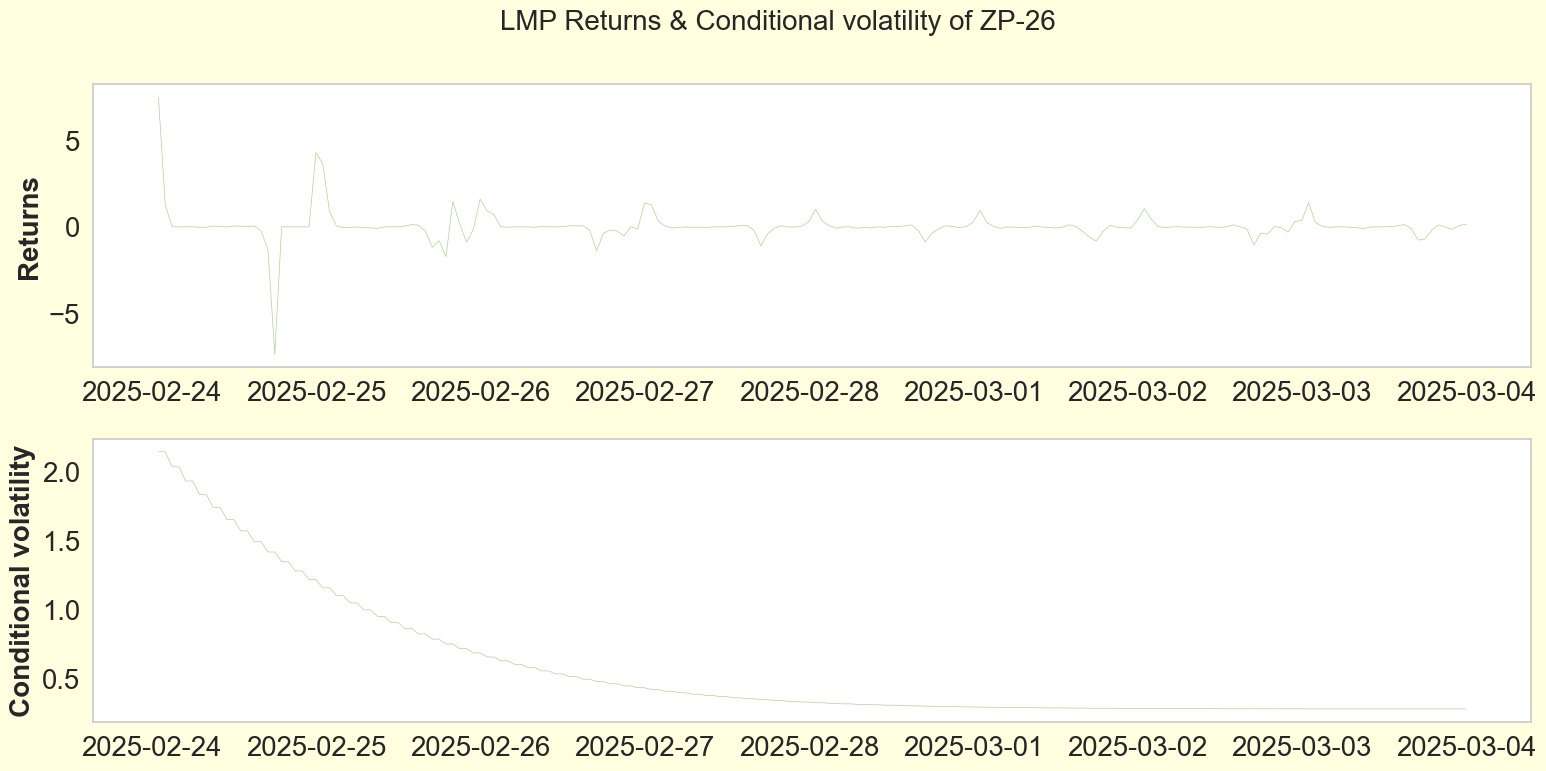

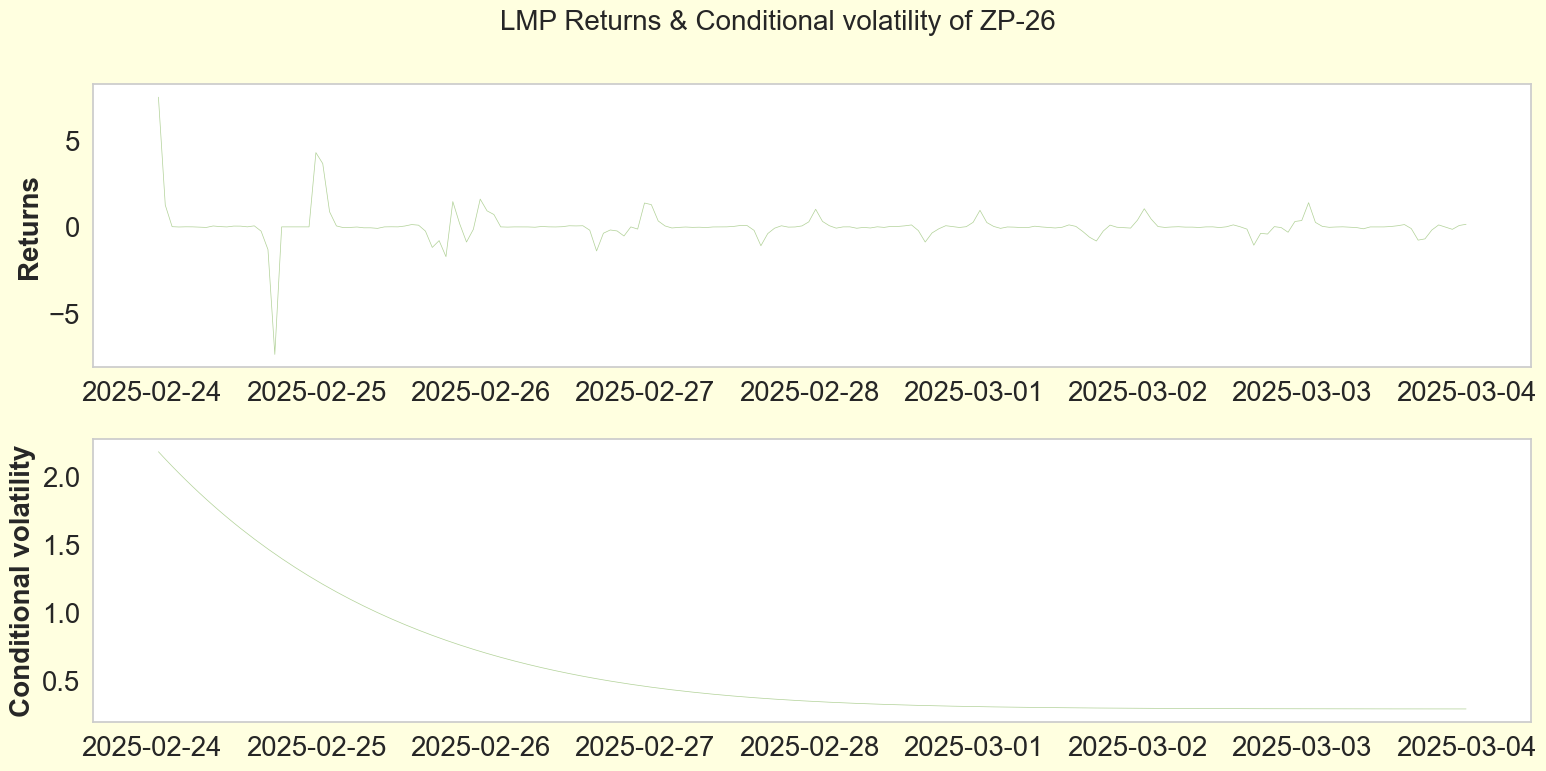

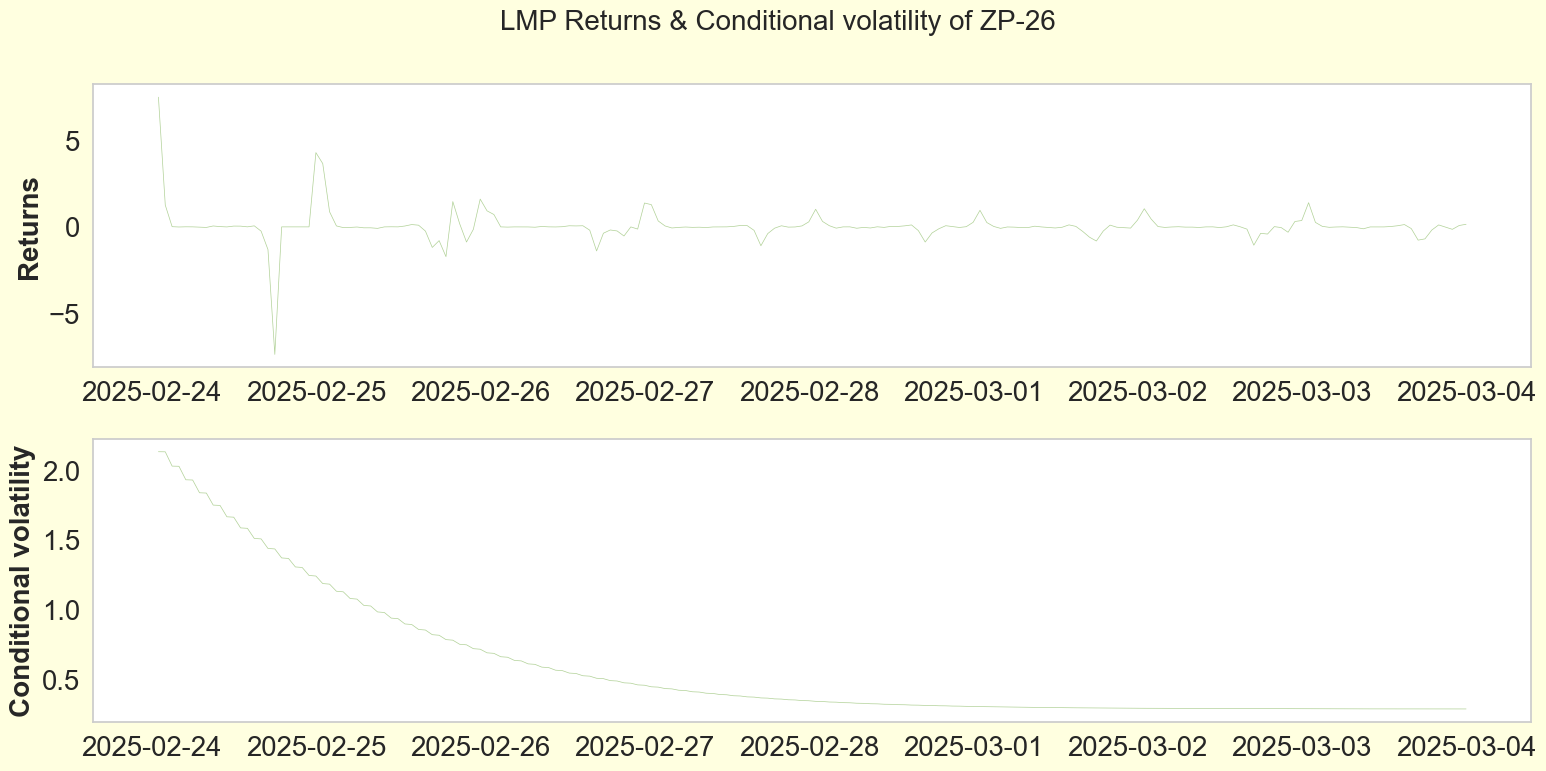

In [18]:
name = 'test_returns'

df = imputed_df.copy()
df = winsorize_outliers(df, area_lmp)

df = get_ext_timecols(df)
df_train_complete, df_test_complete = get_train_test(df, split_date, test_end, time_delta)

arima_orders = [(1,0,1), (2,0,2)]
garch_orders = [(1,1), (1,2)]

for i in range(len(area_lmp)):
    
    area = areas[i]
    col = area_lmp[i]
    
    series = transform_series(df_test_complete[col])
    returns = series.diff().dropna()

    check_stationarity(returns)
    pacf_display(returns, area, status='test_modified')

    for best_arima_order in arima_orders:
        
        arima_model = ARIMA(returns, order=best_arima_order).fit()  
        arima_residuals = arima_model.resid

        for best_garch_order in garch_orders:

            garch_model = arch_model(arima_residuals, mean='Zero', vol='Garch', p=best_garch_order[0], q=best_garch_order[1]).fit(disp='off')
            vol = garch_model.conditional_volatility
    
            vis_returns(returns, vol, area, name, var1='Returns', var2='Conditional volatility', status='test_modified')

### ARIMA-GARCH output

Visualize LMP log returns and conditional volatility

In [ ]:
name = 'GARCH_volatility'

df = imputed_df.copy()
df = winsorize_outliers(df, area_lmp)

for i in range(len(area_lmp)):
    
    area = areas[i]
    col = area_lmp[i]
    
    series = transform_series(df[col])
    returns = series.diff().dropna()

    check_stationarity(returns)
    pacf_display(returns, area, status='modified')
    
    best_arima_order = best_ARIMA_order(returns)
    best_garch_order = best_GARCH_order(returns)

    print(best_arima_order, best_garch_order)
    
    arima_model = ARIMA(returns, order=best_arima_order).fit()  
    arima_residuals = arima_model.resid
    
    garch_model = arch_model(arima_residuals, mean='Zero', vol='Garch', p=best_garch_order[0], q=best_garch_order[1]).fit(disp='off')
    vol = garch_model.conditional_volatility
    
    vis_returns(returns, vol, area, name, var1='Returns', var2='Conditional volatility', status='modified')